In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(3944610, 828)
(3944610, 8)
validation
(464344, 828)
(464344, 8)
test
(574820, 828)
(574820, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

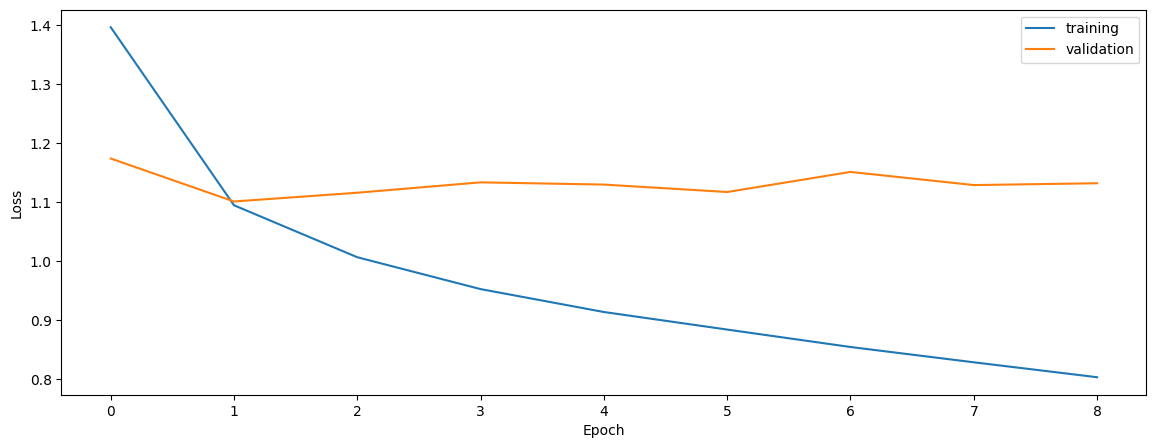

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True
props['collapse_bin'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'BCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_BCE_7_1_0_1_1_1_t1t2_normalized_e_n_e_0_0_e_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1068345, 828)
(1068345, 1)
validation
(123115, 828)
(123115, 1)
test
(152076, 828)
(152076, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_5 (Dense)             (None, 1024)              848896    


 dense_6 (Dense)             (None, 512)               524800    


 dense_7 (Dense)             (None, 256)               131328    


 dense_8 (Dense)             (None, 128)               32896     


 dense_9 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/107 [..............................] - ETA: 2:17 - loss: 0.6715 - STD: 1.6803e-04 - MAE: 0.4734

  5/107 [>.............................] - ETA: 1s - loss: 0.6976 - STD: 8.8199e-04 - MAE: 0.4734  

  9/107 [=>............................] - ETA: 1s - loss: 0.6872 - STD: 0.0014 - MAE: 0.4695    

 13/107 [==>...........................] - ETA: 1s - loss: 0.6831 - STD: 0.0018 - MAE: 0.4750

 17/107 [===>..........................] - ETA: 1s - loss: 0.6795 - STD: 0.0020 - MAE: 0.4731

 21/107 [====>.........................] - ETA: 1s - loss: 0.6767 - STD: 0.0023 - MAE: 0.4713

 25/107 [======>.......................] - ETA: 1s - loss: 0.6747 - STD: 0.0028 - MAE: 0.4722

 29/107 [=======>......................] - ETA: 1s - loss: 0.6731 - STD: 0.0035 - MAE: 0.4726

 32/107 [=======>......................] - ETA: 1s - loss: 0.6722 - STD: 0.0042 - MAE: 0.4722

 36/107 [=========>....................] - ETA: 1s - loss: 0.6706 - STD: 0.0056 - MAE: 0.4717

 39/107 [=========>....................] - ETA: 2s - loss: 0.6691 - STD: 0.0073 - MAE: 0.4714

 42/107 [==========>...................] - ETA: 2s - loss: 0.6674 - STD: 0.0096 - MAE: 0.4705

 45/107 [===========>..................] - ETA: 1s - loss: 0.6653 - STD: 0.0131 - MAE: 0.4693

 49/107 [============>.................] - ETA: 1s - loss: 0.6620 - STD: 0.0200 - MAE: 0.4673

 52/107 [=============>................] - ETA: 1s - loss: 0.6595 - STD: 0.0263 - MAE: 0.4650

 56/107 [==============>...............] - ETA: 1s - loss: 0.6559 - STD: 0.0352 - MAE: 0.4618

 60/107 [===============>..............] - ETA: 1s - loss: 0.6526 - STD: 0.0431 - MAE: 0.4591

 64/107 [================>.............] - ETA: 1s - loss: 0.6494 - STD: 0.0494 - MAE: 0.4567

 68/107 [==================>...........] - ETA: 0s - loss: 0.6460 - STD: 0.0565 - MAE: 0.4541

 72/107 [===================>..........] - ETA: 0s - loss: 0.6428 - STD: 0.0636 - MAE: 0.4512

 76/107 [====================>.........] - ETA: 0s - loss: 0.6393 - STD: 0.0697 - MAE: 0.4486

 80/107 [=====================>........] - ETA: 0s - loss: 0.6359 - STD: 0.0757 - MAE: 0.4459

 84/107 [======================>.......] - ETA: 0s - loss: 0.6319 - STD: 0.0821 - MAE: 0.4427

 88/107 [=======================>......] - ETA: 0s - loss: 0.6292 - STD: 0.0886 - MAE: 0.4397

 91/107 [========================>.....] - ETA: 0s - loss: 0.6270 - STD: 0.0927 - MAE: 0.4371

 94/107 [=========================>....] - ETA: 0s - loss: 0.6249 - STD: 0.0969 - MAE: 0.4353

 98/107 [==========================>...] - ETA: 0s - loss: 0.6223 - STD: 0.1015 - MAE: 0.4329

102/107 [===========================>..] - ETA: 0s - loss: 0.6194 - STD: 0.1055 - MAE: 0.4305

106/107 [============================>.] - ETA: 0s - loss: 0.6167 - STD: 0.1099 - MAE: 0.4284

107/107 [==============================] - 4s 29ms/step - loss: 0.6160 - STD: 0.1109 - MAE: 0.4278 - val_loss: 0.5167 - val_STD: 0.1922 - val_MAE: 0.3479


Epoch 2/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5425 - STD: 0.2295 - MAE: 0.3663

  4/107 [>.............................] - ETA: 2s - loss: 0.5460 - STD: 0.2310 - MAE: 0.3672

  8/107 [=>............................] - ETA: 1s - loss: 0.5459 - STD: 0.2315 - MAE: 0.3663

 12/107 [==>...........................] - ETA: 1s - loss: 0.5455 - STD: 0.2296 - MAE: 0.3655

 16/107 [===>..........................] - ETA: 1s - loss: 0.5438 - STD: 0.2283 - MAE: 0.3654

 20/107 [====>.........................] - ETA: 1s - loss: 0.5432 - STD: 0.2286 - MAE: 0.3653

 24/107 [=====>........................] - ETA: 1s - loss: 0.5430 - STD: 0.2294 - MAE: 0.3648

 28/107 [======>.......................] - ETA: 1s - loss: 0.5427 - STD: 0.2307 - MAE: 0.3644

 32/107 [=======>......................] - ETA: 1s - loss: 0.5422 - STD: 0.2314 - MAE: 0.3639

 35/107 [========>.....................] - ETA: 1s - loss: 0.5421 - STD: 0.2314 - MAE: 0.3638

 39/107 [=========>....................] - ETA: 1s - loss: 0.5420 - STD: 0.2316 - MAE: 0.3638

 43/107 [===========>..................] - ETA: 1s - loss: 0.5413 - STD: 0.2319 - MAE: 0.3633

 47/107 [============>.................] - ETA: 0s - loss: 0.5409 - STD: 0.2326 - MAE: 0.3629

 51/107 [=============>................] - ETA: 0s - loss: 0.5403 - STD: 0.2332 - MAE: 0.3625

 55/107 [==============>...............] - ETA: 0s - loss: 0.5400 - STD: 0.2337 - MAE: 0.3622

 59/107 [===============>..............] - ETA: 0s - loss: 0.5397 - STD: 0.2341 - MAE: 0.3620

 63/107 [================>.............] - ETA: 0s - loss: 0.5394 - STD: 0.2344 - MAE: 0.3618

 67/107 [=================>............] - ETA: 0s - loss: 0.5392 - STD: 0.2348 - MAE: 0.3615

 71/107 [==================>...........] - ETA: 0s - loss: 0.5388 - STD: 0.2352 - MAE: 0.3612

 75/107 [====================>.........] - ETA: 0s - loss: 0.5384 - STD: 0.2356 - MAE: 0.3609

 79/107 [=====================>........] - ETA: 0s - loss: 0.5382 - STD: 0.2359 - MAE: 0.3606

 83/107 [======================>.......] - ETA: 0s - loss: 0.5380 - STD: 0.2363 - MAE: 0.3604

 87/107 [=======================>......] - ETA: 0s - loss: 0.5377 - STD: 0.2364 - MAE: 0.3602

 91/107 [========================>.....] - ETA: 0s - loss: 0.5375 - STD: 0.2365 - MAE: 0.3601

 95/107 [=========================>....] - ETA: 0s - loss: 0.5375 - STD: 0.2366 - MAE: 0.3600

 99/107 [==========================>...] - ETA: 0s - loss: 0.5375 - STD: 0.2367 - MAE: 0.3600

102/107 [===========================>..] - ETA: 0s - loss: 0.5374 - STD: 0.2367 - MAE: 0.3599

106/107 [============================>.] - ETA: 0s - loss: 0.5372 - STD: 0.2368 - MAE: 0.3598

107/107 [==============================] - 2s 18ms/step - loss: 0.5371 - STD: 0.2368 - MAE: 0.3597 - val_loss: 0.5011 - val_STD: 0.1983 - val_MAE: 0.3315


Epoch 3/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5382 - STD: 0.2367 - MAE: 0.3570

  5/107 [>.............................] - ETA: 1s - loss: 0.5353 - STD: 0.2395 - MAE: 0.3568

  9/107 [=>............................] - ETA: 1s - loss: 0.5336 - STD: 0.2410 - MAE: 0.3565

 13/107 [==>...........................] - ETA: 1s - loss: 0.5338 - STD: 0.2419 - MAE: 0.3560

 17/107 [===>..........................] - ETA: 1s - loss: 0.5335 - STD: 0.2419 - MAE: 0.3558

 21/107 [====>.........................] - ETA: 1s - loss: 0.5330 - STD: 0.2416 - MAE: 0.3556

 25/107 [======>.......................] - ETA: 1s - loss: 0.5334 - STD: 0.2416 - MAE: 0.3559

 29/107 [=======>......................] - ETA: 1s - loss: 0.5334 - STD: 0.2412 - MAE: 0.3560

 33/107 [========>.....................] - ETA: 1s - loss: 0.5329 - STD: 0.2411 - MAE: 0.3558

 37/107 [=========>....................] - ETA: 1s - loss: 0.5327 - STD: 0.2411 - MAE: 0.3555

 41/107 [==========>...................] - ETA: 0s - loss: 0.5334 - STD: 0.2410 - MAE: 0.3556

 45/107 [===========>..................] - ETA: 0s - loss: 0.5331 - STD: 0.2406 - MAE: 0.3555

 49/107 [============>.................] - ETA: 0s - loss: 0.5328 - STD: 0.2406 - MAE: 0.3555

 53/107 [=============>................] - ETA: 0s - loss: 0.5322 - STD: 0.2410 - MAE: 0.3551

 57/107 [==============>...............] - ETA: 0s - loss: 0.5318 - STD: 0.2417 - MAE: 0.3546

 61/107 [================>.............] - ETA: 0s - loss: 0.5319 - STD: 0.2418 - MAE: 0.3546

 65/107 [=================>............] - ETA: 0s - loss: 0.5322 - STD: 0.2417 - MAE: 0.3547

 69/107 [==================>...........] - ETA: 0s - loss: 0.5322 - STD: 0.2416 - MAE: 0.3549

 73/107 [===================>..........] - ETA: 0s - loss: 0.5321 - STD: 0.2415 - MAE: 0.3549

 77/107 [====================>.........] - ETA: 0s - loss: 0.5319 - STD: 0.2416 - MAE: 0.3548

 80/107 [=====================>........] - ETA: 0s - loss: 0.5317 - STD: 0.2417 - MAE: 0.3546

 84/107 [======================>.......] - ETA: 0s - loss: 0.5316 - STD: 0.2420 - MAE: 0.3546

 88/107 [=======================>......] - ETA: 0s - loss: 0.5314 - STD: 0.2422 - MAE: 0.3544

 92/107 [========================>.....] - ETA: 0s - loss: 0.5313 - STD: 0.2425 - MAE: 0.3543

 96/107 [=========================>....] - ETA: 0s - loss: 0.5313 - STD: 0.2426 - MAE: 0.3542

100/107 [===========================>..] - ETA: 0s - loss: 0.5311 - STD: 0.2426 - MAE: 0.3541

104/107 [============================>.] - ETA: 0s - loss: 0.5311 - STD: 0.2426 - MAE: 0.3540

107/107 [==============================] - 2s 18ms/step - loss: 0.5310 - STD: 0.2426 - MAE: 0.3540 - val_loss: 0.4911 - val_STD: 0.2043 - val_MAE: 0.3313


Epoch 4/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5235 - STD: 0.2471 - MAE: 0.3517

  4/107 [>.............................] - ETA: 1s - loss: 0.5249 - STD: 0.2456 - MAE: 0.3505

  8/107 [=>............................] - ETA: 1s - loss: 0.5244 - STD: 0.2470 - MAE: 0.3496

 12/107 [==>...........................] - ETA: 1s - loss: 0.5246 - STD: 0.2477 - MAE: 0.3495

 16/107 [===>..........................] - ETA: 1s - loss: 0.5255 - STD: 0.2476 - MAE: 0.3499

 20/107 [====>.........................] - ETA: 1s - loss: 0.5261 - STD: 0.2474 - MAE: 0.3502

 24/107 [=====>........................] - ETA: 1s - loss: 0.5265 - STD: 0.2468 - MAE: 0.3505

 28/107 [======>.......................] - ETA: 1s - loss: 0.5264 - STD: 0.2463 - MAE: 0.3507

 32/107 [=======>......................] - ETA: 1s - loss: 0.5268 - STD: 0.2466 - MAE: 0.3507

 36/107 [=========>....................] - ETA: 1s - loss: 0.5267 - STD: 0.2466 - MAE: 0.3507

 40/107 [==========>...................] - ETA: 1s - loss: 0.5270 - STD: 0.2462 - MAE: 0.3508

 44/107 [===========>..................] - ETA: 0s - loss: 0.5265 - STD: 0.2459 - MAE: 0.3506

 48/107 [============>.................] - ETA: 0s - loss: 0.5265 - STD: 0.2464 - MAE: 0.3504

 52/107 [=============>................] - ETA: 0s - loss: 0.5265 - STD: 0.2465 - MAE: 0.3504

 56/107 [==============>...............] - ETA: 0s - loss: 0.5260 - STD: 0.2464 - MAE: 0.3503

 60/107 [===============>..............] - ETA: 0s - loss: 0.5259 - STD: 0.2467 - MAE: 0.3501

 64/107 [================>.............] - ETA: 0s - loss: 0.5257 - STD: 0.2471 - MAE: 0.3498

 68/107 [==================>...........] - ETA: 0s - loss: 0.5258 - STD: 0.2472 - MAE: 0.3499

 72/107 [===================>..........] - ETA: 0s - loss: 0.5257 - STD: 0.2470 - MAE: 0.3499

 76/107 [====================>.........] - ETA: 0s - loss: 0.5257 - STD: 0.2470 - MAE: 0.3498

 80/107 [=====================>........] - ETA: 0s - loss: 0.5257 - STD: 0.2469 - MAE: 0.3498

 84/107 [======================>.......] - ETA: 0s - loss: 0.5257 - STD: 0.2471 - MAE: 0.3498

 88/107 [=======================>......] - ETA: 0s - loss: 0.5256 - STD: 0.2472 - MAE: 0.3498

 92/107 [========================>.....] - ETA: 0s - loss: 0.5257 - STD: 0.2470 - MAE: 0.3497

 96/107 [=========================>....] - ETA: 0s - loss: 0.5255 - STD: 0.2470 - MAE: 0.3497

100/107 [===========================>..] - ETA: 0s - loss: 0.5255 - STD: 0.2471 - MAE: 0.3496

104/107 [============================>.] - ETA: 0s - loss: 0.5255 - STD: 0.2472 - MAE: 0.3496

107/107 [==============================] - 2s 18ms/step - loss: 0.5253 - STD: 0.2473 - MAE: 0.3495 - val_loss: 0.4834 - val_STD: 0.2129 - val_MAE: 0.3304


Epoch 5/10000


  1/107 [..............................] - ETA: 5s - loss: 0.5230 - STD: 0.2540 - MAE: 0.3519

  4/107 [>.............................] - ETA: 1s - loss: 0.5236 - STD: 0.2515 - MAE: 0.3482

  8/107 [=>............................] - ETA: 1s - loss: 0.5246 - STD: 0.2500 - MAE: 0.3473

 11/107 [==>...........................] - ETA: 1s - loss: 0.5235 - STD: 0.2493 - MAE: 0.3473

 15/107 [===>..........................] - ETA: 1s - loss: 0.5231 - STD: 0.2498 - MAE: 0.3470

 19/107 [====>.........................] - ETA: 1s - loss: 0.5230 - STD: 0.2493 - MAE: 0.3473

 23/107 [=====>........................] - ETA: 1s - loss: 0.5224 - STD: 0.2493 - MAE: 0.3472

 27/107 [======>.......................] - ETA: 1s - loss: 0.5225 - STD: 0.2502 - MAE: 0.3469

 31/107 [=======>......................] - ETA: 1s - loss: 0.5224 - STD: 0.2503 - MAE: 0.3468

 35/107 [========>.....................] - ETA: 1s - loss: 0.5226 - STD: 0.2496 - MAE: 0.3473

 39/107 [=========>....................] - ETA: 1s - loss: 0.5229 - STD: 0.2490 - MAE: 0.3475

 43/107 [===========>..................] - ETA: 0s - loss: 0.5226 - STD: 0.2496 - MAE: 0.3473

 47/107 [============>.................] - ETA: 0s - loss: 0.5228 - STD: 0.2499 - MAE: 0.3471

 51/107 [=============>................] - ETA: 0s - loss: 0.5225 - STD: 0.2498 - MAE: 0.3470

 55/107 [==============>...............] - ETA: 0s - loss: 0.5223 - STD: 0.2499 - MAE: 0.3470

 59/107 [===============>..............] - ETA: 0s - loss: 0.5220 - STD: 0.2500 - MAE: 0.3468

 63/107 [================>.............] - ETA: 0s - loss: 0.5218 - STD: 0.2501 - MAE: 0.3467

 67/107 [=================>............] - ETA: 0s - loss: 0.5214 - STD: 0.2506 - MAE: 0.3464

 71/107 [==================>...........] - ETA: 0s - loss: 0.5216 - STD: 0.2508 - MAE: 0.3464

 75/107 [====================>.........] - ETA: 0s - loss: 0.5215 - STD: 0.2504 - MAE: 0.3465

 79/107 [=====================>........] - ETA: 0s - loss: 0.5213 - STD: 0.2505 - MAE: 0.3464

 83/107 [======================>.......] - ETA: 0s - loss: 0.5209 - STD: 0.2507 - MAE: 0.3461

 87/107 [=======================>......] - ETA: 0s - loss: 0.5207 - STD: 0.2510 - MAE: 0.3459

 90/107 [========================>.....] - ETA: 0s - loss: 0.5204 - STD: 0.2512 - MAE: 0.3457

 94/107 [=========================>....] - ETA: 0s - loss: 0.5202 - STD: 0.2512 - MAE: 0.3456

 98/107 [==========================>...] - ETA: 0s - loss: 0.5200 - STD: 0.2514 - MAE: 0.3454

102/107 [===========================>..] - ETA: 0s - loss: 0.5196 - STD: 0.2517 - MAE: 0.3451

106/107 [============================>.] - ETA: 0s - loss: 0.5196 - STD: 0.2519 - MAE: 0.3450

107/107 [==============================] - 2s 17ms/step - loss: 0.5195 - STD: 0.2518 - MAE: 0.3450 - val_loss: 0.4866 - val_STD: 0.1998 - val_MAE: 0.3192


Epoch 6/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5220 - STD: 0.2419 - MAE: 0.3443

  5/107 [>.............................] - ETA: 1s - loss: 0.5209 - STD: 0.2496 - MAE: 0.3461

  9/107 [=>............................] - ETA: 1s - loss: 0.5223 - STD: 0.2498 - MAE: 0.3451

 13/107 [==>...........................] - ETA: 1s - loss: 0.5208 - STD: 0.2502 - MAE: 0.3453

 17/107 [===>..........................] - ETA: 1s - loss: 0.5197 - STD: 0.2509 - MAE: 0.3453

 20/107 [====>.........................] - ETA: 1s - loss: 0.5195 - STD: 0.2517 - MAE: 0.3449

 24/107 [=====>........................] - ETA: 1s - loss: 0.5199 - STD: 0.2514 - MAE: 0.3444

 28/107 [======>.......................] - ETA: 1s - loss: 0.5192 - STD: 0.2512 - MAE: 0.3445

 32/107 [=======>......................] - ETA: 1s - loss: 0.5196 - STD: 0.2516 - MAE: 0.3448

 36/107 [=========>....................] - ETA: 1s - loss: 0.5204 - STD: 0.2503 - MAE: 0.3449

 40/107 [==========>...................] - ETA: 1s - loss: 0.5201 - STD: 0.2501 - MAE: 0.3448

 44/107 [===========>..................] - ETA: 0s - loss: 0.5195 - STD: 0.2505 - MAE: 0.3445

 48/107 [============>.................] - ETA: 0s - loss: 0.5191 - STD: 0.2508 - MAE: 0.3443

 52/107 [=============>................] - ETA: 0s - loss: 0.5186 - STD: 0.2511 - MAE: 0.3440

 56/107 [==============>...............] - ETA: 0s - loss: 0.5185 - STD: 0.2513 - MAE: 0.3438

 60/107 [===============>..............] - ETA: 0s - loss: 0.5186 - STD: 0.2511 - MAE: 0.3439

 64/107 [================>.............] - ETA: 0s - loss: 0.5179 - STD: 0.2514 - MAE: 0.3437

 68/107 [==================>...........] - ETA: 0s - loss: 0.5174 - STD: 0.2521 - MAE: 0.3432

 72/107 [===================>..........] - ETA: 0s - loss: 0.5172 - STD: 0.2523 - MAE: 0.3431

 76/107 [====================>.........] - ETA: 0s - loss: 0.5168 - STD: 0.2525 - MAE: 0.3429

 80/107 [=====================>........] - ETA: 0s - loss: 0.5165 - STD: 0.2529 - MAE: 0.3427

 84/107 [======================>.......] - ETA: 0s - loss: 0.5163 - STD: 0.2531 - MAE: 0.3426

 88/107 [=======================>......] - ETA: 0s - loss: 0.5161 - STD: 0.2531 - MAE: 0.3425

 92/107 [========================>.....] - ETA: 0s - loss: 0.5160 - STD: 0.2535 - MAE: 0.3423

 96/107 [=========================>....] - ETA: 0s - loss: 0.5158 - STD: 0.2537 - MAE: 0.3422

100/107 [===========================>..] - ETA: 0s - loss: 0.5159 - STD: 0.2536 - MAE: 0.3420

104/107 [============================>.] - ETA: 0s - loss: 0.5160 - STD: 0.2535 - MAE: 0.3420

107/107 [==============================] - 2s 17ms/step - loss: 0.5164 - STD: 0.2533 - MAE: 0.3421 - val_loss: 0.4898 - val_STD: 0.2109 - val_MAE: 0.3466


Epoch 7/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5317 - STD: 0.2464 - MAE: 0.3664

  4/107 [>.............................] - ETA: 1s - loss: 0.5195 - STD: 0.2394 - MAE: 0.3515

  8/107 [=>............................] - ETA: 1s - loss: 0.5182 - STD: 0.2482 - MAE: 0.3465

 12/107 [==>...........................] - ETA: 1s - loss: 0.5160 - STD: 0.2508 - MAE: 0.3443

 16/107 [===>..........................] - ETA: 1s - loss: 0.5157 - STD: 0.2509 - MAE: 0.3441

 20/107 [====>.........................] - ETA: 1s - loss: 0.5146 - STD: 0.2526 - MAE: 0.3430

 24/107 [=====>........................] - ETA: 1s - loss: 0.5139 - STD: 0.2538 - MAE: 0.3420

 28/107 [======>.......................] - ETA: 1s - loss: 0.5134 - STD: 0.2537 - MAE: 0.3418

 32/107 [=======>......................] - ETA: 1s - loss: 0.5131 - STD: 0.2547 - MAE: 0.3414

 36/107 [=========>....................] - ETA: 1s - loss: 0.5124 - STD: 0.2556 - MAE: 0.3407

 40/107 [==========>...................] - ETA: 1s - loss: 0.5120 - STD: 0.2561 - MAE: 0.3404

 44/107 [===========>..................] - ETA: 0s - loss: 0.5120 - STD: 0.2565 - MAE: 0.3400

 48/107 [============>.................] - ETA: 0s - loss: 0.5119 - STD: 0.2563 - MAE: 0.3402

 52/107 [=============>................] - ETA: 0s - loss: 0.5115 - STD: 0.2567 - MAE: 0.3398

 56/107 [==============>...............] - ETA: 0s - loss: 0.5112 - STD: 0.2570 - MAE: 0.3395

 60/107 [===============>..............] - ETA: 0s - loss: 0.5110 - STD: 0.2573 - MAE: 0.3392

 64/107 [================>.............] - ETA: 0s - loss: 0.5105 - STD: 0.2574 - MAE: 0.3390

 68/107 [==================>...........] - ETA: 0s - loss: 0.5104 - STD: 0.2576 - MAE: 0.3388

 72/107 [===================>..........] - ETA: 0s - loss: 0.5105 - STD: 0.2576 - MAE: 0.3388

 76/107 [====================>.........] - ETA: 0s - loss: 0.5105 - STD: 0.2576 - MAE: 0.3387

 80/107 [=====================>........] - ETA: 0s - loss: 0.5105 - STD: 0.2576 - MAE: 0.3386

 84/107 [======================>.......] - ETA: 0s - loss: 0.5103 - STD: 0.2578 - MAE: 0.3385

 88/107 [=======================>......] - ETA: 0s - loss: 0.5106 - STD: 0.2576 - MAE: 0.3384

 92/107 [========================>.....] - ETA: 0s - loss: 0.5107 - STD: 0.2574 - MAE: 0.3385

 96/107 [=========================>....] - ETA: 0s - loss: 0.5109 - STD: 0.2573 - MAE: 0.3387

100/107 [===========================>..] - ETA: 0s - loss: 0.5108 - STD: 0.2571 - MAE: 0.3387

104/107 [============================>.] - ETA: 0s - loss: 0.5106 - STD: 0.2572 - MAE: 0.3385

107/107 [==============================] - 2s 18ms/step - loss: 0.5106 - STD: 0.2573 - MAE: 0.3384 - val_loss: 0.4700 - val_STD: 0.2185 - val_MAE: 0.3162


Epoch 8/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4984 - STD: 0.2595 - MAE: 0.3356

  4/107 [>.............................] - ETA: 1s - loss: 0.5048 - STD: 0.2595 - MAE: 0.3364

  8/107 [=>............................] - ETA: 1s - loss: 0.5066 - STD: 0.2620 - MAE: 0.3361

 11/107 [==>...........................] - ETA: 1s - loss: 0.5081 - STD: 0.2601 - MAE: 0.3378

 15/107 [===>..........................] - ETA: 1s - loss: 0.5088 - STD: 0.2588 - MAE: 0.3374

 19/107 [====>.........................] - ETA: 1s - loss: 0.5086 - STD: 0.2593 - MAE: 0.3365

 23/107 [=====>........................] - ETA: 1s - loss: 0.5092 - STD: 0.2596 - MAE: 0.3371

 27/107 [======>.......................] - ETA: 1s - loss: 0.5088 - STD: 0.2590 - MAE: 0.3366

 30/107 [=======>......................] - ETA: 1s - loss: 0.5087 - STD: 0.2590 - MAE: 0.3364

 34/107 [========>.....................] - ETA: 1s - loss: 0.5085 - STD: 0.2586 - MAE: 0.3366

 38/107 [=========>....................] - ETA: 1s - loss: 0.5082 - STD: 0.2588 - MAE: 0.3366

 42/107 [==========>...................] - ETA: 1s - loss: 0.5078 - STD: 0.2592 - MAE: 0.3360

 46/107 [===========>..................] - ETA: 0s - loss: 0.5072 - STD: 0.2593 - MAE: 0.3359

 50/107 [=============>................] - ETA: 0s - loss: 0.5074 - STD: 0.2597 - MAE: 0.3358

 54/107 [==============>...............] - ETA: 0s - loss: 0.5077 - STD: 0.2593 - MAE: 0.3360

 58/107 [===============>..............] - ETA: 0s - loss: 0.5078 - STD: 0.2595 - MAE: 0.3359

 62/107 [================>.............] - ETA: 0s - loss: 0.5088 - STD: 0.2593 - MAE: 0.3363

 66/107 [=================>............] - ETA: 0s - loss: 0.5092 - STD: 0.2583 - MAE: 0.3368

 70/107 [==================>...........] - ETA: 0s - loss: 0.5096 - STD: 0.2580 - MAE: 0.3367

 74/107 [===================>..........] - ETA: 0s - loss: 0.5096 - STD: 0.2580 - MAE: 0.3368

 78/107 [====================>.........] - ETA: 0s - loss: 0.5092 - STD: 0.2578 - MAE: 0.3368

 82/107 [=====================>........] - ETA: 0s - loss: 0.5091 - STD: 0.2581 - MAE: 0.3365

 86/107 [=======================>......] - ETA: 0s - loss: 0.5088 - STD: 0.2581 - MAE: 0.3366

 90/107 [========================>.....] - ETA: 0s - loss: 0.5088 - STD: 0.2583 - MAE: 0.3366

 94/107 [=========================>....] - ETA: 0s - loss: 0.5087 - STD: 0.2584 - MAE: 0.3366

 97/107 [==========================>...] - ETA: 0s - loss: 0.5088 - STD: 0.2584 - MAE: 0.3365

101/107 [===========================>..] - ETA: 0s - loss: 0.5090 - STD: 0.2583 - MAE: 0.3367

105/107 [============================>.] - ETA: 0s - loss: 0.5092 - STD: 0.2580 - MAE: 0.3368

107/107 [==============================] - 2s 18ms/step - loss: 0.5094 - STD: 0.2580 - MAE: 0.3368 - val_loss: 0.4675 - val_STD: 0.2238 - val_MAE: 0.3197


Epoch 9/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5072 - STD: 0.2650 - MAE: 0.3413

  5/107 [>.............................] - ETA: 1s - loss: 0.5088 - STD: 0.2582 - MAE: 0.3375

  9/107 [=>............................] - ETA: 1s - loss: 0.5045 - STD: 0.2614 - MAE: 0.3340

 13/107 [==>...........................] - ETA: 1s - loss: 0.5051 - STD: 0.2607 - MAE: 0.3341

 17/107 [===>..........................] - ETA: 1s - loss: 0.5055 - STD: 0.2595 - MAE: 0.3349

 21/107 [====>.........................] - ETA: 1s - loss: 0.5050 - STD: 0.2605 - MAE: 0.3341

 25/107 [======>.......................] - ETA: 1s - loss: 0.5054 - STD: 0.2607 - MAE: 0.3346

 29/107 [=======>......................] - ETA: 1s - loss: 0.5052 - STD: 0.2607 - MAE: 0.3348

 33/107 [========>.....................] - ETA: 1s - loss: 0.5048 - STD: 0.2616 - MAE: 0.3343

 37/107 [=========>....................] - ETA: 1s - loss: 0.5046 - STD: 0.2616 - MAE: 0.3343

 41/107 [==========>...................] - ETA: 1s - loss: 0.5048 - STD: 0.2615 - MAE: 0.3343

 45/107 [===========>..................] - ETA: 0s - loss: 0.5044 - STD: 0.2616 - MAE: 0.3342

 49/107 [============>.................] - ETA: 0s - loss: 0.5039 - STD: 0.2622 - MAE: 0.3337

 53/107 [=============>................] - ETA: 0s - loss: 0.5039 - STD: 0.2622 - MAE: 0.3337

 57/107 [==============>...............] - ETA: 0s - loss: 0.5035 - STD: 0.2625 - MAE: 0.3335

 61/107 [================>.............] - ETA: 0s - loss: 0.5034 - STD: 0.2630 - MAE: 0.3331

 65/107 [=================>............] - ETA: 0s - loss: 0.5036 - STD: 0.2626 - MAE: 0.3334

 69/107 [==================>...........] - ETA: 0s - loss: 0.5035 - STD: 0.2628 - MAE: 0.3333

 73/107 [===================>..........] - ETA: 0s - loss: 0.5033 - STD: 0.2628 - MAE: 0.3331

 77/107 [====================>.........] - ETA: 0s - loss: 0.5030 - STD: 0.2628 - MAE: 0.3330

 81/107 [=====================>........] - ETA: 0s - loss: 0.5025 - STD: 0.2633 - MAE: 0.3326

 84/107 [======================>.......] - ETA: 0s - loss: 0.5023 - STD: 0.2635 - MAE: 0.3323

 87/107 [=======================>......] - ETA: 0s - loss: 0.5022 - STD: 0.2638 - MAE: 0.3321

 91/107 [========================>.....] - ETA: 0s - loss: 0.5021 - STD: 0.2637 - MAE: 0.3323

 95/107 [=========================>....] - ETA: 0s - loss: 0.5022 - STD: 0.2636 - MAE: 0.3322

 99/107 [==========================>...] - ETA: 0s - loss: 0.5023 - STD: 0.2636 - MAE: 0.3322

103/107 [===========================>..] - ETA: 0s - loss: 0.5023 - STD: 0.2634 - MAE: 0.3322

107/107 [==============================] - ETA: 0s - loss: 0.5022 - STD: 0.2636 - MAE: 0.3321

107/107 [==============================] - 2s 18ms/step - loss: 0.5022 - STD: 0.2636 - MAE: 0.3321 - val_loss: 0.4659 - val_STD: 0.2207 - val_MAE: 0.3090


Epoch 10/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4920 - STD: 0.2645 - MAE: 0.3264

  5/107 [>.............................] - ETA: 1s - loss: 0.4981 - STD: 0.2627 - MAE: 0.3320

  9/107 [=>............................] - ETA: 1s - loss: 0.4979 - STD: 0.2656 - MAE: 0.3303

 13/107 [==>...........................] - ETA: 1s - loss: 0.4975 - STD: 0.2662 - MAE: 0.3293

 17/107 [===>..........................] - ETA: 1s - loss: 0.4967 - STD: 0.2659 - MAE: 0.3282

 21/107 [====>.........................] - ETA: 1s - loss: 0.4978 - STD: 0.2662 - MAE: 0.3289

 25/107 [======>.......................] - ETA: 1s - loss: 0.4993 - STD: 0.2651 - MAE: 0.3293

 29/107 [=======>......................] - ETA: 1s - loss: 0.5006 - STD: 0.2649 - MAE: 0.3304

 33/107 [========>.....................] - ETA: 1s - loss: 0.5024 - STD: 0.2639 - MAE: 0.3308

 37/107 [=========>....................] - ETA: 1s - loss: 0.5034 - STD: 0.2628 - MAE: 0.3315

 41/107 [==========>...................] - ETA: 1s - loss: 0.5053 - STD: 0.2614 - MAE: 0.3329

 45/107 [===========>..................] - ETA: 0s - loss: 0.5059 - STD: 0.2608 - MAE: 0.3334

 49/107 [============>.................] - ETA: 0s - loss: 0.5053 - STD: 0.2608 - MAE: 0.3332

 53/107 [=============>................] - ETA: 0s - loss: 0.5048 - STD: 0.2609 - MAE: 0.3329

 57/107 [==============>...............] - ETA: 0s - loss: 0.5044 - STD: 0.2611 - MAE: 0.3328

 61/107 [================>.............] - ETA: 0s - loss: 0.5040 - STD: 0.2613 - MAE: 0.3326

 65/107 [=================>............] - ETA: 0s - loss: 0.5038 - STD: 0.2615 - MAE: 0.3327

 69/107 [==================>...........] - ETA: 0s - loss: 0.5033 - STD: 0.2618 - MAE: 0.3325

 73/107 [===================>..........] - ETA: 0s - loss: 0.5029 - STD: 0.2622 - MAE: 0.3322

 77/107 [====================>.........] - ETA: 0s - loss: 0.5025 - STD: 0.2627 - MAE: 0.3319

 81/107 [=====================>........] - ETA: 0s - loss: 0.5023 - STD: 0.2629 - MAE: 0.3317

 85/107 [======================>.......] - ETA: 0s - loss: 0.5019 - STD: 0.2631 - MAE: 0.3315

 89/107 [=======================>......] - ETA: 0s - loss: 0.5017 - STD: 0.2634 - MAE: 0.3313

 93/107 [=========================>....] - ETA: 0s - loss: 0.5015 - STD: 0.2635 - MAE: 0.3312

 97/107 [==========================>...] - ETA: 0s - loss: 0.5013 - STD: 0.2637 - MAE: 0.3311

101/107 [===========================>..] - ETA: 0s - loss: 0.5010 - STD: 0.2641 - MAE: 0.3308

105/107 [============================>.] - ETA: 0s - loss: 0.5009 - STD: 0.2641 - MAE: 0.3308

107/107 [==============================] - 2s 17ms/step - loss: 0.5009 - STD: 0.2642 - MAE: 0.3308 - val_loss: 0.4778 - val_STD: 0.2124 - val_MAE: 0.3045


Epoch 11/10000


  1/107 [..............................] - ETA: 4s - loss: 0.5089 - STD: 0.2571 - MAE: 0.3277

  5/107 [>.............................] - ETA: 1s - loss: 0.5064 - STD: 0.2627 - MAE: 0.3329

  9/107 [=>............................] - ETA: 1s - loss: 0.5030 - STD: 0.2638 - MAE: 0.3304

 13/107 [==>...........................] - ETA: 1s - loss: 0.5013 - STD: 0.2646 - MAE: 0.3303

 17/107 [===>..........................] - ETA: 1s - loss: 0.4998 - STD: 0.2653 - MAE: 0.3298

 21/107 [====>.........................] - ETA: 1s - loss: 0.4995 - STD: 0.2654 - MAE: 0.3290

 25/107 [======>.......................] - ETA: 1s - loss: 0.5000 - STD: 0.2657 - MAE: 0.3295

 29/107 [=======>......................] - ETA: 1s - loss: 0.5011 - STD: 0.2641 - MAE: 0.3296

 33/107 [========>.....................] - ETA: 1s - loss: 0.5023 - STD: 0.2640 - MAE: 0.3300

 37/107 [=========>....................] - ETA: 1s - loss: 0.5047 - STD: 0.2623 - MAE: 0.3316

 41/107 [==========>...................] - ETA: 1s - loss: 0.5054 - STD: 0.2619 - MAE: 0.3322

 45/107 [===========>..................] - ETA: 0s - loss: 0.5059 - STD: 0.2612 - MAE: 0.3324

 49/107 [============>.................] - ETA: 0s - loss: 0.5064 - STD: 0.2600 - MAE: 0.3332

 53/107 [=============>................] - ETA: 0s - loss: 0.5063 - STD: 0.2599 - MAE: 0.3330

 57/107 [==============>...............] - ETA: 0s - loss: 0.5062 - STD: 0.2598 - MAE: 0.3331

 61/107 [================>.............] - ETA: 0s - loss: 0.5059 - STD: 0.2597 - MAE: 0.3333

 65/107 [=================>............] - ETA: 0s - loss: 0.5056 - STD: 0.2600 - MAE: 0.3331

 69/107 [==================>...........] - ETA: 0s - loss: 0.5049 - STD: 0.2604 - MAE: 0.3327

 73/107 [===================>..........] - ETA: 0s - loss: 0.5043 - STD: 0.2608 - MAE: 0.3325

 77/107 [====================>.........] - ETA: 0s - loss: 0.5037 - STD: 0.2613 - MAE: 0.3321

 81/107 [=====================>........] - ETA: 0s - loss: 0.5029 - STD: 0.2617 - MAE: 0.3316

 85/107 [======================>.......] - ETA: 0s - loss: 0.5023 - STD: 0.2624 - MAE: 0.3312

 89/107 [=======================>......] - ETA: 0s - loss: 0.5021 - STD: 0.2626 - MAE: 0.3311

 93/107 [=========================>....] - ETA: 0s - loss: 0.5019 - STD: 0.2627 - MAE: 0.3310

 97/107 [==========================>...] - ETA: 0s - loss: 0.5016 - STD: 0.2631 - MAE: 0.3308

101/107 [===========================>..] - ETA: 0s - loss: 0.5011 - STD: 0.2634 - MAE: 0.3305

105/107 [============================>.] - ETA: 0s - loss: 0.5009 - STD: 0.2638 - MAE: 0.3304

107/107 [==============================] - 2s 17ms/step - loss: 0.5007 - STD: 0.2638 - MAE: 0.3303 - val_loss: 0.4610 - val_STD: 0.2254 - val_MAE: 0.3096


Epoch 12/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4880 - STD: 0.2710 - MAE: 0.3257

  4/107 [>.............................] - ETA: 1s - loss: 0.4974 - STD: 0.2708 - MAE: 0.3284

  8/107 [=>............................] - ETA: 1s - loss: 0.4921 - STD: 0.2704 - MAE: 0.3258

 12/107 [==>...........................] - ETA: 1s - loss: 0.4915 - STD: 0.2713 - MAE: 0.3243

 16/107 [===>..........................] - ETA: 1s - loss: 0.4919 - STD: 0.2709 - MAE: 0.3247

 20/107 [====>.........................] - ETA: 1s - loss: 0.4930 - STD: 0.2714 - MAE: 0.3246

 24/107 [=====>........................] - ETA: 1s - loss: 0.4935 - STD: 0.2703 - MAE: 0.3252

 28/107 [======>.......................] - ETA: 1s - loss: 0.4942 - STD: 0.2700 - MAE: 0.3256

 32/107 [=======>......................] - ETA: 1s - loss: 0.4940 - STD: 0.2697 - MAE: 0.3255

 35/107 [========>.....................] - ETA: 1s - loss: 0.4944 - STD: 0.2697 - MAE: 0.3257

 39/107 [=========>....................] - ETA: 1s - loss: 0.4940 - STD: 0.2696 - MAE: 0.3258

 43/107 [===========>..................] - ETA: 1s - loss: 0.4944 - STD: 0.2698 - MAE: 0.3259

 47/107 [============>.................] - ETA: 0s - loss: 0.4940 - STD: 0.2695 - MAE: 0.3259

 51/107 [=============>................] - ETA: 0s - loss: 0.4937 - STD: 0.2700 - MAE: 0.3254

 55/107 [==============>...............] - ETA: 0s - loss: 0.4938 - STD: 0.2700 - MAE: 0.3256

 59/107 [===============>..............] - ETA: 0s - loss: 0.4947 - STD: 0.2696 - MAE: 0.3256

 63/107 [================>.............] - ETA: 0s - loss: 0.4946 - STD: 0.2696 - MAE: 0.3256

 67/107 [=================>............] - ETA: 0s - loss: 0.4947 - STD: 0.2697 - MAE: 0.3257

 71/107 [==================>...........] - ETA: 0s - loss: 0.4950 - STD: 0.2692 - MAE: 0.3258

 75/107 [====================>.........] - ETA: 0s - loss: 0.4950 - STD: 0.2690 - MAE: 0.3258

 79/107 [=====================>........] - ETA: 0s - loss: 0.4958 - STD: 0.2686 - MAE: 0.3264

 83/107 [======================>.......] - ETA: 0s - loss: 0.4961 - STD: 0.2682 - MAE: 0.3266

 87/107 [=======================>......] - ETA: 0s - loss: 0.4962 - STD: 0.2681 - MAE: 0.3266

 91/107 [========================>.....] - ETA: 0s - loss: 0.4963 - STD: 0.2680 - MAE: 0.3266

 95/107 [=========================>....] - ETA: 0s - loss: 0.4966 - STD: 0.2678 - MAE: 0.3269

 99/107 [==========================>...] - ETA: 0s - loss: 0.4964 - STD: 0.2678 - MAE: 0.3269

103/107 [===========================>..] - ETA: 0s - loss: 0.4962 - STD: 0.2679 - MAE: 0.3268

107/107 [==============================] - ETA: 0s - loss: 0.4959 - STD: 0.2679 - MAE: 0.3267

107/107 [==============================] - 2s 18ms/step - loss: 0.4959 - STD: 0.2679 - MAE: 0.3267 - val_loss: 0.4578 - val_STD: 0.2274 - val_MAE: 0.3050


Epoch 13/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4883 - STD: 0.2751 - MAE: 0.3248

  5/107 [>.............................] - ETA: 1s - loss: 0.4911 - STD: 0.2730 - MAE: 0.3251

  9/107 [=>............................] - ETA: 1s - loss: 0.4930 - STD: 0.2704 - MAE: 0.3249

 13/107 [==>...........................] - ETA: 1s - loss: 0.4934 - STD: 0.2699 - MAE: 0.3243

 17/107 [===>..........................] - ETA: 1s - loss: 0.4933 - STD: 0.2699 - MAE: 0.3246

 21/107 [====>.........................] - ETA: 1s - loss: 0.4940 - STD: 0.2697 - MAE: 0.3256

 25/107 [======>.......................] - ETA: 1s - loss: 0.4944 - STD: 0.2691 - MAE: 0.3259

 29/107 [=======>......................] - ETA: 1s - loss: 0.4941 - STD: 0.2689 - MAE: 0.3258

 33/107 [========>.....................] - ETA: 1s - loss: 0.4936 - STD: 0.2694 - MAE: 0.3253

 37/107 [=========>....................] - ETA: 1s - loss: 0.4936 - STD: 0.2696 - MAE: 0.3254

 40/107 [==========>...................] - ETA: 1s - loss: 0.4933 - STD: 0.2698 - MAE: 0.3252

 44/107 [===========>..................] - ETA: 0s - loss: 0.4935 - STD: 0.2697 - MAE: 0.3251

 48/107 [============>.................] - ETA: 0s - loss: 0.4932 - STD: 0.2696 - MAE: 0.3250

 52/107 [=============>................] - ETA: 0s - loss: 0.4930 - STD: 0.2700 - MAE: 0.3248

 56/107 [==============>...............] - ETA: 0s - loss: 0.4929 - STD: 0.2701 - MAE: 0.3247

 60/107 [===============>..............] - ETA: 0s - loss: 0.4926 - STD: 0.2703 - MAE: 0.3246

 64/107 [================>.............] - ETA: 0s - loss: 0.4924 - STD: 0.2704 - MAE: 0.3246

 68/107 [==================>...........] - ETA: 0s - loss: 0.4923 - STD: 0.2704 - MAE: 0.3244

 72/107 [===================>..........] - ETA: 0s - loss: 0.4923 - STD: 0.2706 - MAE: 0.3244

 76/107 [====================>.........] - ETA: 0s - loss: 0.4927 - STD: 0.2704 - MAE: 0.3244

 80/107 [=====================>........] - ETA: 0s - loss: 0.4928 - STD: 0.2704 - MAE: 0.3245

 84/107 [======================>.......] - ETA: 0s - loss: 0.4929 - STD: 0.2704 - MAE: 0.3246

 88/107 [=======================>......] - ETA: 0s - loss: 0.4928 - STD: 0.2702 - MAE: 0.3245

 92/107 [========================>.....] - ETA: 0s - loss: 0.4927 - STD: 0.2703 - MAE: 0.3244

 96/107 [=========================>....] - ETA: 0s - loss: 0.4932 - STD: 0.2701 - MAE: 0.3247

100/107 [===========================>..] - ETA: 0s - loss: 0.4938 - STD: 0.2696 - MAE: 0.3249

104/107 [============================>.] - ETA: 0s - loss: 0.4942 - STD: 0.2694 - MAE: 0.3250

107/107 [==============================] - 2s 17ms/step - loss: 0.4942 - STD: 0.2692 - MAE: 0.3251 - val_loss: 0.4562 - val_STD: 0.2251 - val_MAE: 0.3093


Epoch 14/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4949 - STD: 0.2716 - MAE: 0.3312

  5/107 [>.............................] - ETA: 1s - loss: 0.4953 - STD: 0.2727 - MAE: 0.3278

  9/107 [=>............................] - ETA: 1s - loss: 0.4937 - STD: 0.2679 - MAE: 0.3277

 13/107 [==>...........................] - ETA: 1s - loss: 0.4917 - STD: 0.2695 - MAE: 0.3250

 17/107 [===>..........................] - ETA: 1s - loss: 0.4918 - STD: 0.2695 - MAE: 0.3251

 21/107 [====>.........................] - ETA: 1s - loss: 0.4909 - STD: 0.2698 - MAE: 0.3249

 25/107 [======>.......................] - ETA: 1s - loss: 0.4905 - STD: 0.2706 - MAE: 0.3242

 29/107 [=======>......................] - ETA: 1s - loss: 0.4898 - STD: 0.2708 - MAE: 0.3239

 33/107 [========>.....................] - ETA: 1s - loss: 0.4892 - STD: 0.2710 - MAE: 0.3236

 37/107 [=========>....................] - ETA: 1s - loss: 0.4887 - STD: 0.2716 - MAE: 0.3232

 41/107 [==========>...................] - ETA: 0s - loss: 0.4887 - STD: 0.2714 - MAE: 0.3230

 45/107 [===========>..................] - ETA: 0s - loss: 0.4885 - STD: 0.2721 - MAE: 0.3227

 49/107 [============>.................] - ETA: 0s - loss: 0.4884 - STD: 0.2719 - MAE: 0.3227

 53/107 [=============>................] - ETA: 0s - loss: 0.4881 - STD: 0.2725 - MAE: 0.3222

 57/107 [==============>...............] - ETA: 0s - loss: 0.4877 - STD: 0.2727 - MAE: 0.3220

 61/107 [================>.............] - ETA: 0s - loss: 0.4880 - STD: 0.2730 - MAE: 0.3216

 65/107 [=================>............] - ETA: 0s - loss: 0.4885 - STD: 0.2727 - MAE: 0.3217

 69/107 [==================>...........] - ETA: 0s - loss: 0.4890 - STD: 0.2728 - MAE: 0.3219

 73/107 [===================>..........] - ETA: 0s - loss: 0.4893 - STD: 0.2723 - MAE: 0.3219

 77/107 [====================>.........] - ETA: 0s - loss: 0.4895 - STD: 0.2722 - MAE: 0.3221

 81/107 [=====================>........] - ETA: 0s - loss: 0.4895 - STD: 0.2721 - MAE: 0.3223

 85/107 [======================>.......] - ETA: 0s - loss: 0.4896 - STD: 0.2720 - MAE: 0.3225

 89/107 [=======================>......] - ETA: 0s - loss: 0.4897 - STD: 0.2719 - MAE: 0.3225

 93/107 [=========================>....] - ETA: 0s - loss: 0.4898 - STD: 0.2717 - MAE: 0.3225

 97/107 [==========================>...] - ETA: 0s - loss: 0.4897 - STD: 0.2718 - MAE: 0.3226

101/107 [===========================>..] - ETA: 0s - loss: 0.4898 - STD: 0.2719 - MAE: 0.3226

105/107 [============================>.] - ETA: 0s - loss: 0.4898 - STD: 0.2718 - MAE: 0.3227

107/107 [==============================] - 2s 17ms/step - loss: 0.4899 - STD: 0.2719 - MAE: 0.3227 - val_loss: 0.4565 - val_STD: 0.2293 - val_MAE: 0.2999


Epoch 15/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4860 - STD: 0.2802 - MAE: 0.3194

  4/107 [>.............................] - ETA: 1s - loss: 0.4842 - STD: 0.2777 - MAE: 0.3179

  8/107 [=>............................] - ETA: 1s - loss: 0.4863 - STD: 0.2730 - MAE: 0.3206

 12/107 [==>...........................] - ETA: 1s - loss: 0.4873 - STD: 0.2737 - MAE: 0.3210

 15/107 [===>..........................] - ETA: 1s - loss: 0.4861 - STD: 0.2741 - MAE: 0.3207

 18/107 [====>.........................] - ETA: 1s - loss: 0.4864 - STD: 0.2744 - MAE: 0.3207

 21/107 [====>.........................] - ETA: 1s - loss: 0.4863 - STD: 0.2749 - MAE: 0.3205

 24/107 [=====>........................] - ETA: 1s - loss: 0.4862 - STD: 0.2746 - MAE: 0.3202

 28/107 [======>.......................] - ETA: 1s - loss: 0.4865 - STD: 0.2748 - MAE: 0.3205

 32/107 [=======>......................] - ETA: 1s - loss: 0.4861 - STD: 0.2750 - MAE: 0.3200

 36/107 [=========>....................] - ETA: 1s - loss: 0.4865 - STD: 0.2750 - MAE: 0.3201

 40/107 [==========>...................] - ETA: 1s - loss: 0.4868 - STD: 0.2749 - MAE: 0.3201

 44/107 [===========>..................] - ETA: 1s - loss: 0.4869 - STD: 0.2747 - MAE: 0.3203

 48/107 [============>.................] - ETA: 0s - loss: 0.4871 - STD: 0.2743 - MAE: 0.3202

 52/107 [=============>................] - ETA: 0s - loss: 0.4879 - STD: 0.2739 - MAE: 0.3204

 56/107 [==============>...............] - ETA: 0s - loss: 0.4899 - STD: 0.2735 - MAE: 0.3214

 60/107 [===============>..............] - ETA: 0s - loss: 0.4929 - STD: 0.2718 - MAE: 0.3225

 64/107 [================>.............] - ETA: 0s - loss: 0.4943 - STD: 0.2714 - MAE: 0.3226

 68/107 [==================>...........] - ETA: 0s - loss: 0.4953 - STD: 0.2695 - MAE: 0.3241

 72/107 [===================>..........] - ETA: 0s - loss: 0.4959 - STD: 0.2693 - MAE: 0.3243

 76/107 [====================>.........] - ETA: 0s - loss: 0.4959 - STD: 0.2688 - MAE: 0.3247

 80/107 [=====================>........] - ETA: 0s - loss: 0.4959 - STD: 0.2680 - MAE: 0.3252

 84/107 [======================>.......] - ETA: 0s - loss: 0.4955 - STD: 0.2681 - MAE: 0.3250

 88/107 [=======================>......] - ETA: 0s - loss: 0.4951 - STD: 0.2682 - MAE: 0.3250

 92/107 [========================>.....] - ETA: 0s - loss: 0.4947 - STD: 0.2680 - MAE: 0.3250

 95/107 [=========================>....] - ETA: 0s - loss: 0.4945 - STD: 0.2685 - MAE: 0.3248

 99/107 [==========================>...] - ETA: 0s - loss: 0.4942 - STD: 0.2688 - MAE: 0.3247

103/107 [===========================>..] - ETA: 0s - loss: 0.4939 - STD: 0.2688 - MAE: 0.3246

107/107 [==============================] - ETA: 0s - loss: 0.4934 - STD: 0.2691 - MAE: 0.3243

107/107 [==============================] - 2s 18ms/step - loss: 0.4934 - STD: 0.2691 - MAE: 0.3243 - val_loss: 0.4553 - val_STD: 0.2298 - val_MAE: 0.2972


Epoch 16/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4787 - STD: 0.2839 - MAE: 0.3130

  5/107 [>.............................] - ETA: 1s - loss: 0.4855 - STD: 0.2761 - MAE: 0.3195

  9/107 [=>............................] - ETA: 1s - loss: 0.4855 - STD: 0.2742 - MAE: 0.3210

 13/107 [==>...........................] - ETA: 1s - loss: 0.4854 - STD: 0.2755 - MAE: 0.3201

 17/107 [===>..........................] - ETA: 1s - loss: 0.4854 - STD: 0.2744 - MAE: 0.3206

 21/107 [====>.........................] - ETA: 1s - loss: 0.4847 - STD: 0.2752 - MAE: 0.3200

 24/107 [=====>........................] - ETA: 1s - loss: 0.4853 - STD: 0.2754 - MAE: 0.3199

 27/107 [======>.......................] - ETA: 1s - loss: 0.4848 - STD: 0.2753 - MAE: 0.3198

 31/107 [=======>......................] - ETA: 1s - loss: 0.4850 - STD: 0.2758 - MAE: 0.3196

 35/107 [========>.....................] - ETA: 1s - loss: 0.4847 - STD: 0.2756 - MAE: 0.3195

 39/107 [=========>....................] - ETA: 1s - loss: 0.4844 - STD: 0.2760 - MAE: 0.3190

 42/107 [==========>...................] - ETA: 1s - loss: 0.4842 - STD: 0.2759 - MAE: 0.3190

 45/107 [===========>..................] - ETA: 1s - loss: 0.4841 - STD: 0.2758 - MAE: 0.3190

 48/107 [============>.................] - ETA: 0s - loss: 0.4843 - STD: 0.2759 - MAE: 0.3191

 51/107 [=============>................] - ETA: 0s - loss: 0.4841 - STD: 0.2761 - MAE: 0.3189

 54/107 [==============>...............] - ETA: 0s - loss: 0.4842 - STD: 0.2761 - MAE: 0.3190

 58/107 [===============>..............] - ETA: 0s - loss: 0.4847 - STD: 0.2758 - MAE: 0.3189

 62/107 [================>.............] - ETA: 0s - loss: 0.4848 - STD: 0.2758 - MAE: 0.3188

 66/107 [=================>............] - ETA: 0s - loss: 0.4853 - STD: 0.2757 - MAE: 0.3193

 70/107 [==================>...........] - ETA: 0s - loss: 0.4856 - STD: 0.2756 - MAE: 0.3192

 74/107 [===================>..........] - ETA: 0s - loss: 0.4859 - STD: 0.2753 - MAE: 0.3194

 78/107 [====================>.........] - ETA: 0s - loss: 0.4859 - STD: 0.2754 - MAE: 0.3195

 82/107 [=====================>........] - ETA: 0s - loss: 0.4857 - STD: 0.2754 - MAE: 0.3194

 86/107 [=======================>......] - ETA: 0s - loss: 0.4855 - STD: 0.2752 - MAE: 0.3194

 90/107 [========================>.....] - ETA: 0s - loss: 0.4853 - STD: 0.2754 - MAE: 0.3192

 94/107 [=========================>....] - ETA: 0s - loss: 0.4854 - STD: 0.2752 - MAE: 0.3194

 98/107 [==========================>...] - ETA: 0s - loss: 0.4851 - STD: 0.2754 - MAE: 0.3191

102/107 [===========================>..] - ETA: 0s - loss: 0.4850 - STD: 0.2755 - MAE: 0.3191

106/107 [============================>.] - ETA: 0s - loss: 0.4850 - STD: 0.2754 - MAE: 0.3191

107/107 [==============================] - 2s 18ms/step - loss: 0.4850 - STD: 0.2755 - MAE: 0.3191 - val_loss: 0.4525 - val_STD: 0.2345 - val_MAE: 0.2947


Epoch 17/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4809 - STD: 0.2861 - MAE: 0.3124

  5/107 [>.............................] - ETA: 1s - loss: 0.4804 - STD: 0.2807 - MAE: 0.3157

  8/107 [=>............................] - ETA: 1s - loss: 0.4805 - STD: 0.2801 - MAE: 0.3153

 11/107 [==>...........................] - ETA: 1s - loss: 0.4804 - STD: 0.2791 - MAE: 0.3156

 14/107 [==>...........................] - ETA: 1s - loss: 0.4811 - STD: 0.2794 - MAE: 0.3160

 17/107 [===>..........................] - ETA: 1s - loss: 0.4809 - STD: 0.2796 - MAE: 0.3160

 20/107 [====>.........................] - ETA: 1s - loss: 0.4806 - STD: 0.2792 - MAE: 0.3161

 24/107 [=====>........................] - ETA: 1s - loss: 0.4814 - STD: 0.2788 - MAE: 0.3158

 28/107 [======>.......................] - ETA: 1s - loss: 0.4821 - STD: 0.2786 - MAE: 0.3167

 32/107 [=======>......................] - ETA: 1s - loss: 0.4823 - STD: 0.2784 - MAE: 0.3165

 36/107 [=========>....................] - ETA: 1s - loss: 0.4834 - STD: 0.2782 - MAE: 0.3169

 40/107 [==========>...................] - ETA: 1s - loss: 0.4848 - STD: 0.2778 - MAE: 0.3176

 44/107 [===========>..................] - ETA: 1s - loss: 0.4853 - STD: 0.2773 - MAE: 0.3177

 47/107 [============>.................] - ETA: 0s - loss: 0.4857 - STD: 0.2770 - MAE: 0.3180

 50/107 [=============>................] - ETA: 0s - loss: 0.4857 - STD: 0.2763 - MAE: 0.3183

 54/107 [==============>...............] - ETA: 0s - loss: 0.4857 - STD: 0.2764 - MAE: 0.3182

 58/107 [===============>..............] - ETA: 0s - loss: 0.4860 - STD: 0.2761 - MAE: 0.3185

 62/107 [================>.............] - ETA: 0s - loss: 0.4860 - STD: 0.2758 - MAE: 0.3187

 65/107 [=================>............] - ETA: 0s - loss: 0.4861 - STD: 0.2756 - MAE: 0.3189

 68/107 [==================>...........] - ETA: 0s - loss: 0.4866 - STD: 0.2755 - MAE: 0.3190

 71/107 [==================>...........] - ETA: 0s - loss: 0.4864 - STD: 0.2752 - MAE: 0.3190

 74/107 [===================>..........] - ETA: 0s - loss: 0.4862 - STD: 0.2753 - MAE: 0.3189

 77/107 [====================>.........] - ETA: 0s - loss: 0.4860 - STD: 0.2755 - MAE: 0.3188

 81/107 [=====================>........] - ETA: 0s - loss: 0.4856 - STD: 0.2755 - MAE: 0.3186

 85/107 [======================>.......] - ETA: 0s - loss: 0.4857 - STD: 0.2756 - MAE: 0.3185

 89/107 [=======================>......] - ETA: 0s - loss: 0.4855 - STD: 0.2755 - MAE: 0.3184

 93/107 [=========================>....] - ETA: 0s - loss: 0.4857 - STD: 0.2755 - MAE: 0.3186

 97/107 [==========================>...] - ETA: 0s - loss: 0.4857 - STD: 0.2757 - MAE: 0.3186

101/107 [===========================>..] - ETA: 0s - loss: 0.4857 - STD: 0.2754 - MAE: 0.3187

105/107 [============================>.] - ETA: 0s - loss: 0.4856 - STD: 0.2755 - MAE: 0.3185

107/107 [==============================] - 2s 18ms/step - loss: 0.4857 - STD: 0.2755 - MAE: 0.3186 - val_loss: 0.4677 - val_STD: 0.2140 - val_MAE: 0.3020


Epoch 18/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4871 - STD: 0.2607 - MAE: 0.3202

  5/107 [>.............................] - ETA: 1s - loss: 0.4850 - STD: 0.2759 - MAE: 0.3181

  9/107 [=>............................] - ETA: 1s - loss: 0.4837 - STD: 0.2768 - MAE: 0.3181

 13/107 [==>...........................] - ETA: 1s - loss: 0.4854 - STD: 0.2753 - MAE: 0.3185

 17/107 [===>..........................] - ETA: 1s - loss: 0.4859 - STD: 0.2748 - MAE: 0.3182

 21/107 [====>.........................] - ETA: 1s - loss: 0.4861 - STD: 0.2745 - MAE: 0.3186

 25/107 [======>.......................] - ETA: 1s - loss: 0.4861 - STD: 0.2746 - MAE: 0.3190

 28/107 [======>.......................] - ETA: 1s - loss: 0.4862 - STD: 0.2746 - MAE: 0.3188

 31/107 [=======>......................] - ETA: 1s - loss: 0.4865 - STD: 0.2744 - MAE: 0.3189

 35/107 [========>.....................] - ETA: 1s - loss: 0.4860 - STD: 0.2745 - MAE: 0.3189

 39/107 [=========>....................] - ETA: 1s - loss: 0.4857 - STD: 0.2746 - MAE: 0.3189

 42/107 [==========>...................] - ETA: 1s - loss: 0.4858 - STD: 0.2744 - MAE: 0.3189

 45/107 [===========>..................] - ETA: 1s - loss: 0.4858 - STD: 0.2745 - MAE: 0.3189

 48/107 [============>.................] - ETA: 0s - loss: 0.4857 - STD: 0.2749 - MAE: 0.3187

 51/107 [=============>................] - ETA: 0s - loss: 0.4854 - STD: 0.2750 - MAE: 0.3186

 54/107 [==============>...............] - ETA: 0s - loss: 0.4850 - STD: 0.2752 - MAE: 0.3185

 58/107 [===============>..............] - ETA: 0s - loss: 0.4849 - STD: 0.2753 - MAE: 0.3185

 62/107 [================>.............] - ETA: 0s - loss: 0.4849 - STD: 0.2755 - MAE: 0.3185

 66/107 [=================>............] - ETA: 0s - loss: 0.4847 - STD: 0.2753 - MAE: 0.3185

 70/107 [==================>...........] - ETA: 0s - loss: 0.4842 - STD: 0.2758 - MAE: 0.3182

 74/107 [===================>..........] - ETA: 0s - loss: 0.4841 - STD: 0.2758 - MAE: 0.3183

 78/107 [====================>.........] - ETA: 0s - loss: 0.4839 - STD: 0.2761 - MAE: 0.3180

 82/107 [=====================>........] - ETA: 0s - loss: 0.4835 - STD: 0.2763 - MAE: 0.3178

 86/107 [=======================>......] - ETA: 0s - loss: 0.4833 - STD: 0.2765 - MAE: 0.3176

 90/107 [========================>.....] - ETA: 0s - loss: 0.4829 - STD: 0.2767 - MAE: 0.3174

 94/107 [=========================>....] - ETA: 0s - loss: 0.4828 - STD: 0.2769 - MAE: 0.3172

 98/107 [==========================>...] - ETA: 0s - loss: 0.4828 - STD: 0.2770 - MAE: 0.3172

102/107 [===========================>..] - ETA: 0s - loss: 0.4827 - STD: 0.2770 - MAE: 0.3172

106/107 [============================>.] - ETA: 0s - loss: 0.4822 - STD: 0.2773 - MAE: 0.3169

107/107 [==============================] - 2s 18ms/step - loss: 0.4822 - STD: 0.2773 - MAE: 0.3168 - val_loss: 0.4492 - val_STD: 0.2360 - val_MAE: 0.2990


Epoch 19/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4836 - STD: 0.2819 - MAE: 0.3201

  5/107 [>.............................] - ETA: 1s - loss: 0.4774 - STD: 0.2797 - MAE: 0.3157

  9/107 [=>............................] - ETA: 1s - loss: 0.4785 - STD: 0.2810 - MAE: 0.3143

 13/107 [==>...........................] - ETA: 1s - loss: 0.4801 - STD: 0.2801 - MAE: 0.3159

 17/107 [===>..........................] - ETA: 1s - loss: 0.4794 - STD: 0.2807 - MAE: 0.3151

 21/107 [====>.........................] - ETA: 1s - loss: 0.4801 - STD: 0.2807 - MAE: 0.3153

 25/107 [======>.......................] - ETA: 1s - loss: 0.4800 - STD: 0.2808 - MAE: 0.3150

 29/107 [=======>......................] - ETA: 1s - loss: 0.4790 - STD: 0.2809 - MAE: 0.3145

 33/107 [========>.....................] - ETA: 1s - loss: 0.4783 - STD: 0.2813 - MAE: 0.3140

 37/107 [=========>....................] - ETA: 1s - loss: 0.4778 - STD: 0.2813 - MAE: 0.3137

 41/107 [==========>...................] - ETA: 1s - loss: 0.4776 - STD: 0.2816 - MAE: 0.3133

 45/107 [===========>..................] - ETA: 0s - loss: 0.4780 - STD: 0.2816 - MAE: 0.3136

 49/107 [============>.................] - ETA: 0s - loss: 0.4787 - STD: 0.2813 - MAE: 0.3137

 53/107 [=============>................] - ETA: 0s - loss: 0.4787 - STD: 0.2814 - MAE: 0.3136

 57/107 [==============>...............] - ETA: 0s - loss: 0.4786 - STD: 0.2812 - MAE: 0.3138

 61/107 [================>.............] - ETA: 0s - loss: 0.4786 - STD: 0.2813 - MAE: 0.3136

 65/107 [=================>............] - ETA: 0s - loss: 0.4790 - STD: 0.2813 - MAE: 0.3139

 69/107 [==================>...........] - ETA: 0s - loss: 0.4792 - STD: 0.2810 - MAE: 0.3140

 73/107 [===================>..........] - ETA: 0s - loss: 0.4793 - STD: 0.2812 - MAE: 0.3140

 77/107 [====================>.........] - ETA: 0s - loss: 0.4791 - STD: 0.2810 - MAE: 0.3139

 81/107 [=====================>........] - ETA: 0s - loss: 0.4795 - STD: 0.2806 - MAE: 0.3140

 85/107 [======================>.......] - ETA: 0s - loss: 0.4801 - STD: 0.2804 - MAE: 0.3143

 89/107 [=======================>......] - ETA: 0s - loss: 0.4816 - STD: 0.2797 - MAE: 0.3147

 93/107 [=========================>....] - ETA: 0s - loss: 0.4822 - STD: 0.2790 - MAE: 0.3150

 97/107 [==========================>...] - ETA: 0s - loss: 0.4823 - STD: 0.2788 - MAE: 0.3152

101/107 [===========================>..] - ETA: 0s - loss: 0.4823 - STD: 0.2786 - MAE: 0.3153

105/107 [============================>.] - ETA: 0s - loss: 0.4822 - STD: 0.2785 - MAE: 0.3155

107/107 [==============================] - 2s 17ms/step - loss: 0.4822 - STD: 0.2784 - MAE: 0.3155 - val_loss: 0.4504 - val_STD: 0.2255 - val_MAE: 0.2976


Epoch 20/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4861 - STD: 0.2734 - MAE: 0.3206

  5/107 [>.............................] - ETA: 1s - loss: 0.4839 - STD: 0.2705 - MAE: 0.3230

  9/107 [=>............................] - ETA: 1s - loss: 0.4820 - STD: 0.2756 - MAE: 0.3194

 12/107 [==>...........................] - ETA: 1s - loss: 0.4813 - STD: 0.2756 - MAE: 0.3189

 16/107 [===>..........................] - ETA: 1s - loss: 0.4808 - STD: 0.2758 - MAE: 0.3184

 20/107 [====>.........................] - ETA: 1s - loss: 0.4804 - STD: 0.2769 - MAE: 0.3177

 24/107 [=====>........................] - ETA: 1s - loss: 0.4806 - STD: 0.2773 - MAE: 0.3174

 27/107 [======>.......................] - ETA: 1s - loss: 0.4800 - STD: 0.2780 - MAE: 0.3168

 31/107 [=======>......................] - ETA: 1s - loss: 0.4796 - STD: 0.2785 - MAE: 0.3164

 35/107 [========>.....................] - ETA: 1s - loss: 0.4798 - STD: 0.2786 - MAE: 0.3164

 39/107 [=========>....................] - ETA: 1s - loss: 0.4793 - STD: 0.2789 - MAE: 0.3158

 42/107 [==========>...................] - ETA: 1s - loss: 0.4792 - STD: 0.2790 - MAE: 0.3157

 45/107 [===========>..................] - ETA: 1s - loss: 0.4792 - STD: 0.2789 - MAE: 0.3157

 48/107 [============>.................] - ETA: 0s - loss: 0.4794 - STD: 0.2792 - MAE: 0.3154

 51/107 [=============>................] - ETA: 0s - loss: 0.4796 - STD: 0.2791 - MAE: 0.3156

 54/107 [==============>...............] - ETA: 0s - loss: 0.4795 - STD: 0.2794 - MAE: 0.3152

 57/107 [==============>...............] - ETA: 0s - loss: 0.4796 - STD: 0.2792 - MAE: 0.3153

 60/107 [===============>..............] - ETA: 0s - loss: 0.4798 - STD: 0.2793 - MAE: 0.3151

 63/107 [================>.............] - ETA: 0s - loss: 0.4797 - STD: 0.2793 - MAE: 0.3151

 67/107 [=================>............] - ETA: 0s - loss: 0.4794 - STD: 0.2796 - MAE: 0.3147

 70/107 [==================>...........] - ETA: 0s - loss: 0.4796 - STD: 0.2795 - MAE: 0.3149

 73/107 [===================>..........] - ETA: 0s - loss: 0.4795 - STD: 0.2794 - MAE: 0.3147

 76/107 [====================>.........] - ETA: 0s - loss: 0.4801 - STD: 0.2794 - MAE: 0.3147

 79/107 [=====================>........] - ETA: 0s - loss: 0.4810 - STD: 0.2788 - MAE: 0.3150

 82/107 [=====================>........] - ETA: 0s - loss: 0.4817 - STD: 0.2785 - MAE: 0.3154

 85/107 [======================>.......] - ETA: 0s - loss: 0.4816 - STD: 0.2783 - MAE: 0.3155

 88/107 [=======================>......] - ETA: 0s - loss: 0.4816 - STD: 0.2786 - MAE: 0.3154

 91/107 [========================>.....] - ETA: 0s - loss: 0.4815 - STD: 0.2783 - MAE: 0.3156

 94/107 [=========================>....] - ETA: 0s - loss: 0.4815 - STD: 0.2782 - MAE: 0.3156

 97/107 [==========================>...] - ETA: 0s - loss: 0.4814 - STD: 0.2783 - MAE: 0.3155

100/107 [===========================>..] - ETA: 0s - loss: 0.4814 - STD: 0.2781 - MAE: 0.3156

103/107 [===========================>..] - ETA: 0s - loss: 0.4812 - STD: 0.2781 - MAE: 0.3156

106/107 [============================>.] - ETA: 0s - loss: 0.4811 - STD: 0.2782 - MAE: 0.3154

107/107 [==============================] - 2s 20ms/step - loss: 0.4810 - STD: 0.2783 - MAE: 0.3154 - val_loss: 0.4479 - val_STD: 0.2342 - val_MAE: 0.2943


Epoch 21/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4793 - STD: 0.2843 - MAE: 0.3156

  4/107 [>.............................] - ETA: 1s - loss: 0.4761 - STD: 0.2825 - MAE: 0.3131

  7/107 [>.............................] - ETA: 1s - loss: 0.4774 - STD: 0.2813 - MAE: 0.3141

 10/107 [=>............................] - ETA: 1s - loss: 0.4776 - STD: 0.2812 - MAE: 0.3147

 13/107 [==>...........................] - ETA: 1s - loss: 0.4765 - STD: 0.2806 - MAE: 0.3135

 16/107 [===>..........................] - ETA: 1s - loss: 0.4772 - STD: 0.2801 - MAE: 0.3140

 19/107 [====>.........................] - ETA: 1s - loss: 0.4766 - STD: 0.2796 - MAE: 0.3138

 22/107 [=====>........................] - ETA: 1s - loss: 0.4773 - STD: 0.2796 - MAE: 0.3135

 25/107 [======>.......................] - ETA: 1s - loss: 0.4781 - STD: 0.2797 - MAE: 0.3136

 28/107 [======>.......................] - ETA: 1s - loss: 0.4779 - STD: 0.2796 - MAE: 0.3137

 31/107 [=======>......................] - ETA: 1s - loss: 0.4779 - STD: 0.2801 - MAE: 0.3135

 34/107 [========>.....................] - ETA: 1s - loss: 0.4777 - STD: 0.2803 - MAE: 0.3135

 37/107 [=========>....................] - ETA: 1s - loss: 0.4774 - STD: 0.2808 - MAE: 0.3131

 40/107 [==========>...................] - ETA: 1s - loss: 0.4777 - STD: 0.2805 - MAE: 0.3134

 43/107 [===========>..................] - ETA: 1s - loss: 0.4778 - STD: 0.2807 - MAE: 0.3134

 46/107 [===========>..................] - ETA: 1s - loss: 0.4775 - STD: 0.2805 - MAE: 0.3132

 49/107 [============>.................] - ETA: 1s - loss: 0.4771 - STD: 0.2808 - MAE: 0.3130

 52/107 [=============>................] - ETA: 0s - loss: 0.4769 - STD: 0.2808 - MAE: 0.3127

 55/107 [==============>...............] - ETA: 0s - loss: 0.4769 - STD: 0.2807 - MAE: 0.3128

 58/107 [===============>..............] - ETA: 0s - loss: 0.4768 - STD: 0.2807 - MAE: 0.3126

 61/107 [================>.............] - ETA: 0s - loss: 0.4772 - STD: 0.2807 - MAE: 0.3127

 65/107 [=================>............] - ETA: 0s - loss: 0.4774 - STD: 0.2805 - MAE: 0.3127

 68/107 [==================>...........] - ETA: 0s - loss: 0.4781 - STD: 0.2804 - MAE: 0.3128

 71/107 [==================>...........] - ETA: 0s - loss: 0.4787 - STD: 0.2802 - MAE: 0.3131

 74/107 [===================>..........] - ETA: 0s - loss: 0.4787 - STD: 0.2799 - MAE: 0.3134

 77/107 [====================>.........] - ETA: 0s - loss: 0.4785 - STD: 0.2802 - MAE: 0.3132

 80/107 [=====================>........] - ETA: 0s - loss: 0.4784 - STD: 0.2802 - MAE: 0.3132

 83/107 [======================>.......] - ETA: 0s - loss: 0.4784 - STD: 0.2801 - MAE: 0.3134

 86/107 [=======================>......] - ETA: 0s - loss: 0.4784 - STD: 0.2801 - MAE: 0.3135

 89/107 [=======================>......] - ETA: 0s - loss: 0.4781 - STD: 0.2803 - MAE: 0.3133

 92/107 [========================>.....] - ETA: 0s - loss: 0.4781 - STD: 0.2801 - MAE: 0.3134

 95/107 [=========================>....] - ETA: 0s - loss: 0.4780 - STD: 0.2802 - MAE: 0.3133

 98/107 [==========================>...] - ETA: 0s - loss: 0.4779 - STD: 0.2804 - MAE: 0.3132

101/107 [===========================>..] - ETA: 0s - loss: 0.4778 - STD: 0.2802 - MAE: 0.3133

104/107 [============================>.] - ETA: 0s - loss: 0.4777 - STD: 0.2804 - MAE: 0.3132

107/107 [==============================] - 2s 20ms/step - loss: 0.4776 - STD: 0.2805 - MAE: 0.3131 - val_loss: 0.4489 - val_STD: 0.2340 - val_MAE: 0.2955


Epoch 22/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4754 - STD: 0.2822 - MAE: 0.3133

  5/107 [>.............................] - ETA: 1s - loss: 0.4721 - STD: 0.2824 - MAE: 0.3103

  8/107 [=>............................] - ETA: 1s - loss: 0.4718 - STD: 0.2842 - MAE: 0.3091

 11/107 [==>...........................] - ETA: 1s - loss: 0.4716 - STD: 0.2841 - MAE: 0.3090

 14/107 [==>...........................] - ETA: 1s - loss: 0.4723 - STD: 0.2844 - MAE: 0.3096

 17/107 [===>..........................] - ETA: 1s - loss: 0.4732 - STD: 0.2846 - MAE: 0.3100

 20/107 [====>.........................] - ETA: 1s - loss: 0.4736 - STD: 0.2845 - MAE: 0.3103

 23/107 [=====>........................] - ETA: 1s - loss: 0.4733 - STD: 0.2846 - MAE: 0.3100

 26/107 [======>.......................] - ETA: 1s - loss: 0.4741 - STD: 0.2846 - MAE: 0.3106

 29/107 [=======>......................] - ETA: 1s - loss: 0.4749 - STD: 0.2842 - MAE: 0.3111

 32/107 [=======>......................] - ETA: 1s - loss: 0.4752 - STD: 0.2841 - MAE: 0.3113

 35/107 [========>.....................] - ETA: 1s - loss: 0.4755 - STD: 0.2843 - MAE: 0.3112

 38/107 [=========>....................] - ETA: 1s - loss: 0.4765 - STD: 0.2836 - MAE: 0.3116

 42/107 [==========>...................] - ETA: 1s - loss: 0.4791 - STD: 0.2825 - MAE: 0.3118

 45/107 [===========>..................] - ETA: 1s - loss: 0.4799 - STD: 0.2815 - MAE: 0.3127

 48/107 [============>.................] - ETA: 1s - loss: 0.4799 - STD: 0.2820 - MAE: 0.3124

 51/107 [=============>................] - ETA: 0s - loss: 0.4799 - STD: 0.2814 - MAE: 0.3128

 54/107 [==============>...............] - ETA: 0s - loss: 0.4798 - STD: 0.2814 - MAE: 0.3127

 57/107 [==============>...............] - ETA: 0s - loss: 0.4798 - STD: 0.2812 - MAE: 0.3128

 60/107 [===============>..............] - ETA: 0s - loss: 0.4798 - STD: 0.2807 - MAE: 0.3132

 63/107 [================>.............] - ETA: 0s - loss: 0.4796 - STD: 0.2806 - MAE: 0.3131

 66/107 [=================>............] - ETA: 0s - loss: 0.4796 - STD: 0.2804 - MAE: 0.3133

 69/107 [==================>...........] - ETA: 0s - loss: 0.4794 - STD: 0.2803 - MAE: 0.3134

 72/107 [===================>..........] - ETA: 0s - loss: 0.4791 - STD: 0.2805 - MAE: 0.3131

 76/107 [====================>.........] - ETA: 0s - loss: 0.4792 - STD: 0.2802 - MAE: 0.3133

 79/107 [=====================>........] - ETA: 0s - loss: 0.4792 - STD: 0.2803 - MAE: 0.3133

 82/107 [=====================>........] - ETA: 0s - loss: 0.4792 - STD: 0.2804 - MAE: 0.3132

 85/107 [======================>.......] - ETA: 0s - loss: 0.4789 - STD: 0.2804 - MAE: 0.3132

 88/107 [=======================>......] - ETA: 0s - loss: 0.4789 - STD: 0.2806 - MAE: 0.3130

 91/107 [========================>.....] - ETA: 0s - loss: 0.4789 - STD: 0.2804 - MAE: 0.3132

 94/107 [=========================>....] - ETA: 0s - loss: 0.4787 - STD: 0.2804 - MAE: 0.3131

 97/107 [==========================>...] - ETA: 0s - loss: 0.4784 - STD: 0.2806 - MAE: 0.3128

100/107 [===========================>..] - ETA: 0s - loss: 0.4782 - STD: 0.2805 - MAE: 0.3129

103/107 [===========================>..] - ETA: 0s - loss: 0.4780 - STD: 0.2806 - MAE: 0.3128

107/107 [==============================] - ETA: 0s - loss: 0.4779 - STD: 0.2807 - MAE: 0.3127

107/107 [==============================] - 2s 20ms/step - loss: 0.4779 - STD: 0.2807 - MAE: 0.3127 - val_loss: 0.4504 - val_STD: 0.2312 - val_MAE: 0.2966


Epoch 23/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4739 - STD: 0.2795 - MAE: 0.3129

  4/107 [>.............................] - ETA: 1s - loss: 0.4735 - STD: 0.2819 - MAE: 0.3105

  7/107 [>.............................] - ETA: 1s - loss: 0.4710 - STD: 0.2832 - MAE: 0.3090

 10/107 [=>............................] - ETA: 1s - loss: 0.4716 - STD: 0.2836 - MAE: 0.3091

 13/107 [==>...........................] - ETA: 1s - loss: 0.4715 - STD: 0.2829 - MAE: 0.3096

 16/107 [===>..........................] - ETA: 1s - loss: 0.4718 - STD: 0.2841 - MAE: 0.3088

 19/107 [====>.........................] - ETA: 1s - loss: 0.4727 - STD: 0.2842 - MAE: 0.3088

 22/107 [=====>........................] - ETA: 1s - loss: 0.4730 - STD: 0.2836 - MAE: 0.3092

 25/107 [======>.......................] - ETA: 1s - loss: 0.4737 - STD: 0.2836 - MAE: 0.3094

 28/107 [======>.......................] - ETA: 1s - loss: 0.4745 - STD: 0.2836 - MAE: 0.3096

 31/107 [=======>......................] - ETA: 1s - loss: 0.4744 - STD: 0.2833 - MAE: 0.3100

 34/107 [========>.....................] - ETA: 1s - loss: 0.4754 - STD: 0.2836 - MAE: 0.3099

 38/107 [=========>....................] - ETA: 1s - loss: 0.4768 - STD: 0.2830 - MAE: 0.3104

 42/107 [==========>...................] - ETA: 1s - loss: 0.4790 - STD: 0.2819 - MAE: 0.3118

 45/107 [===========>..................] - ETA: 1s - loss: 0.4792 - STD: 0.2820 - MAE: 0.3116

 48/107 [============>.................] - ETA: 1s - loss: 0.4797 - STD: 0.2817 - MAE: 0.3118

 51/107 [=============>................] - ETA: 0s - loss: 0.4808 - STD: 0.2805 - MAE: 0.3126

 54/107 [==============>...............] - ETA: 0s - loss: 0.4815 - STD: 0.2804 - MAE: 0.3131

 57/107 [==============>...............] - ETA: 0s - loss: 0.4826 - STD: 0.2799 - MAE: 0.3139

 60/107 [===============>..............] - ETA: 0s - loss: 0.4830 - STD: 0.2790 - MAE: 0.3141

 63/107 [================>.............] - ETA: 0s - loss: 0.4834 - STD: 0.2783 - MAE: 0.3145

 66/107 [=================>............] - ETA: 0s - loss: 0.4831 - STD: 0.2781 - MAE: 0.3148

 69/107 [==================>...........] - ETA: 0s - loss: 0.4831 - STD: 0.2781 - MAE: 0.3147

 73/107 [===================>..........] - ETA: 0s - loss: 0.4826 - STD: 0.2777 - MAE: 0.3150

 76/107 [====================>.........] - ETA: 0s - loss: 0.4825 - STD: 0.2777 - MAE: 0.3149

 79/107 [=====================>........] - ETA: 0s - loss: 0.4823 - STD: 0.2776 - MAE: 0.3150

 82/107 [=====================>........] - ETA: 0s - loss: 0.4822 - STD: 0.2776 - MAE: 0.3152

 85/107 [======================>.......] - ETA: 0s - loss: 0.4820 - STD: 0.2778 - MAE: 0.3151

 88/107 [=======================>......] - ETA: 0s - loss: 0.4816 - STD: 0.2778 - MAE: 0.3149

 91/107 [========================>.....] - ETA: 0s - loss: 0.4812 - STD: 0.2779 - MAE: 0.3147

 94/107 [=========================>....] - ETA: 0s - loss: 0.4811 - STD: 0.2781 - MAE: 0.3146

 97/107 [==========================>...] - ETA: 0s - loss: 0.4807 - STD: 0.2782 - MAE: 0.3146

100/107 [===========================>..] - ETA: 0s - loss: 0.4803 - STD: 0.2784 - MAE: 0.3143

103/107 [===========================>..] - ETA: 0s - loss: 0.4800 - STD: 0.2787 - MAE: 0.3141

106/107 [============================>.] - ETA: 0s - loss: 0.4798 - STD: 0.2787 - MAE: 0.3140

107/107 [==============================] - 2s 20ms/step - loss: 0.4797 - STD: 0.2789 - MAE: 0.3139 - val_loss: 0.4526 - val_STD: 0.2305 - val_MAE: 0.2870


Epoch 24/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4783 - STD: 0.2812 - MAE: 0.3072

  4/107 [>.............................] - ETA: 1s - loss: 0.4775 - STD: 0.2831 - MAE: 0.3115

  7/107 [>.............................] - ETA: 1s - loss: 0.4735 - STD: 0.2843 - MAE: 0.3095

 11/107 [==>...........................] - ETA: 1s - loss: 0.4716 - STD: 0.2840 - MAE: 0.3091

 14/107 [==>...........................] - ETA: 1s - loss: 0.4723 - STD: 0.2847 - MAE: 0.3088

 17/107 [===>..........................] - ETA: 1s - loss: 0.4720 - STD: 0.2844 - MAE: 0.3091

 20/107 [====>.........................] - ETA: 1s - loss: 0.4714 - STD: 0.2846 - MAE: 0.3089

 23/107 [=====>........................] - ETA: 1s - loss: 0.4717 - STD: 0.2856 - MAE: 0.3082

 26/107 [======>.......................] - ETA: 1s - loss: 0.4718 - STD: 0.2852 - MAE: 0.3086

 29/107 [=======>......................] - ETA: 1s - loss: 0.4722 - STD: 0.2854 - MAE: 0.3085

 32/107 [=======>......................] - ETA: 1s - loss: 0.4723 - STD: 0.2852 - MAE: 0.3088

 35/107 [========>.....................] - ETA: 1s - loss: 0.4726 - STD: 0.2854 - MAE: 0.3089

 38/107 [=========>....................] - ETA: 1s - loss: 0.4730 - STD: 0.2852 - MAE: 0.3091

 41/107 [==========>...................] - ETA: 1s - loss: 0.4730 - STD: 0.2847 - MAE: 0.3093

 45/107 [===========>..................] - ETA: 1s - loss: 0.4736 - STD: 0.2847 - MAE: 0.3094

 48/107 [============>.................] - ETA: 1s - loss: 0.4735 - STD: 0.2845 - MAE: 0.3096

 51/107 [=============>................] - ETA: 0s - loss: 0.4733 - STD: 0.2843 - MAE: 0.3095

 54/107 [==============>...............] - ETA: 0s - loss: 0.4729 - STD: 0.2844 - MAE: 0.3093

 57/107 [==============>...............] - ETA: 0s - loss: 0.4729 - STD: 0.2846 - MAE: 0.3092

 60/107 [===============>..............] - ETA: 0s - loss: 0.4727 - STD: 0.2845 - MAE: 0.3091

 63/107 [================>.............] - ETA: 0s - loss: 0.4727 - STD: 0.2845 - MAE: 0.3092

 66/107 [=================>............] - ETA: 0s - loss: 0.4727 - STD: 0.2845 - MAE: 0.3091

 69/107 [==================>...........] - ETA: 0s - loss: 0.4730 - STD: 0.2843 - MAE: 0.3093

 72/107 [===================>..........] - ETA: 0s - loss: 0.4731 - STD: 0.2843 - MAE: 0.3093

 75/107 [====================>.........] - ETA: 0s - loss: 0.4732 - STD: 0.2843 - MAE: 0.3093

 78/107 [====================>.........] - ETA: 0s - loss: 0.4731 - STD: 0.2842 - MAE: 0.3092

 81/107 [=====================>........] - ETA: 0s - loss: 0.4732 - STD: 0.2840 - MAE: 0.3093

 84/107 [======================>.......] - ETA: 0s - loss: 0.4732 - STD: 0.2840 - MAE: 0.3093

 87/107 [=======================>......] - ETA: 0s - loss: 0.4731 - STD: 0.2842 - MAE: 0.3092

 90/107 [========================>.....] - ETA: 0s - loss: 0.4731 - STD: 0.2841 - MAE: 0.3094

 93/107 [=========================>....] - ETA: 0s - loss: 0.4732 - STD: 0.2843 - MAE: 0.3094

 96/107 [=========================>....] - ETA: 0s - loss: 0.4730 - STD: 0.2843 - MAE: 0.3093

 99/107 [==========================>...] - ETA: 0s - loss: 0.4730 - STD: 0.2843 - MAE: 0.3093

102/107 [===========================>..] - ETA: 0s - loss: 0.4731 - STD: 0.2842 - MAE: 0.3094

105/107 [============================>.] - ETA: 0s - loss: 0.4731 - STD: 0.2843 - MAE: 0.3093

107/107 [==============================] - 2s 20ms/step - loss: 0.4731 - STD: 0.2843 - MAE: 0.3094 - val_loss: 0.4469 - val_STD: 0.2341 - val_MAE: 0.2978


Epoch 25/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4708 - STD: 0.2826 - MAE: 0.3146

  4/107 [>.............................] - ETA: 1s - loss: 0.4742 - STD: 0.2813 - MAE: 0.3129

  7/107 [>.............................] - ETA: 1s - loss: 0.4713 - STD: 0.2849 - MAE: 0.3095

 10/107 [=>............................] - ETA: 1s - loss: 0.4706 - STD: 0.2855 - MAE: 0.3086

 13/107 [==>...........................] - ETA: 1s - loss: 0.4699 - STD: 0.2850 - MAE: 0.3086

 16/107 [===>..........................] - ETA: 1s - loss: 0.4702 - STD: 0.2852 - MAE: 0.3085

 19/107 [====>.........................] - ETA: 1s - loss: 0.4708 - STD: 0.2856 - MAE: 0.3086

 23/107 [=====>........................] - ETA: 1s - loss: 0.4703 - STD: 0.2853 - MAE: 0.3084

 26/107 [======>.......................] - ETA: 1s - loss: 0.4710 - STD: 0.2853 - MAE: 0.3087

 29/107 [=======>......................] - ETA: 1s - loss: 0.4713 - STD: 0.2855 - MAE: 0.3089

 32/107 [=======>......................] - ETA: 1s - loss: 0.4712 - STD: 0.2855 - MAE: 0.3088

 35/107 [========>.....................] - ETA: 1s - loss: 0.4710 - STD: 0.2859 - MAE: 0.3084

 38/107 [=========>....................] - ETA: 1s - loss: 0.4710 - STD: 0.2858 - MAE: 0.3086

 41/107 [==========>...................] - ETA: 1s - loss: 0.4713 - STD: 0.2859 - MAE: 0.3083

 44/107 [===========>..................] - ETA: 1s - loss: 0.4724 - STD: 0.2855 - MAE: 0.3087

 47/107 [============>.................] - ETA: 1s - loss: 0.4733 - STD: 0.2853 - MAE: 0.3090

 50/107 [=============>................] - ETA: 0s - loss: 0.4747 - STD: 0.2847 - MAE: 0.3095

 53/107 [=============>................] - ETA: 0s - loss: 0.4757 - STD: 0.2842 - MAE: 0.3095

 56/107 [==============>...............] - ETA: 0s - loss: 0.4756 - STD: 0.2838 - MAE: 0.3097

 60/107 [===============>..............] - ETA: 0s - loss: 0.4751 - STD: 0.2838 - MAE: 0.3096

 63/107 [================>.............] - ETA: 0s - loss: 0.4749 - STD: 0.2838 - MAE: 0.3096

 66/107 [=================>............] - ETA: 0s - loss: 0.4748 - STD: 0.2836 - MAE: 0.3097

 69/107 [==================>...........] - ETA: 0s - loss: 0.4747 - STD: 0.2834 - MAE: 0.3098

 72/107 [===================>..........] - ETA: 0s - loss: 0.4747 - STD: 0.2834 - MAE: 0.3099

 75/107 [====================>.........] - ETA: 0s - loss: 0.4747 - STD: 0.2834 - MAE: 0.3099

 78/107 [====================>.........] - ETA: 0s - loss: 0.4747 - STD: 0.2834 - MAE: 0.3100

 81/107 [=====================>........] - ETA: 0s - loss: 0.4746 - STD: 0.2833 - MAE: 0.3100

 84/107 [======================>.......] - ETA: 0s - loss: 0.4743 - STD: 0.2833 - MAE: 0.3098

 87/107 [=======================>......] - ETA: 0s - loss: 0.4742 - STD: 0.2832 - MAE: 0.3099

 90/107 [========================>.....] - ETA: 0s - loss: 0.4741 - STD: 0.2833 - MAE: 0.3098

 93/107 [=========================>....] - ETA: 0s - loss: 0.4741 - STD: 0.2834 - MAE: 0.3098

 96/107 [=========================>....] - ETA: 0s - loss: 0.4738 - STD: 0.2835 - MAE: 0.3098

 99/107 [==========================>...] - ETA: 0s - loss: 0.4735 - STD: 0.2836 - MAE: 0.3095

102/107 [===========================>..] - ETA: 0s - loss: 0.4734 - STD: 0.2837 - MAE: 0.3095

105/107 [============================>.] - ETA: 0s - loss: 0.4730 - STD: 0.2838 - MAE: 0.3093

107/107 [==============================] - 2s 20ms/step - loss: 0.4730 - STD: 0.2840 - MAE: 0.3092 - val_loss: 0.4584 - val_STD: 0.2270 - val_MAE: 0.2870


Epoch 26/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4696 - STD: 0.2802 - MAE: 0.3013

  5/107 [>.............................] - ETA: 1s - loss: 0.4702 - STD: 0.2840 - MAE: 0.3077

  8/107 [=>............................] - ETA: 1s - loss: 0.4714 - STD: 0.2874 - MAE: 0.3062

 11/107 [==>...........................] - ETA: 1s - loss: 0.4709 - STD: 0.2859 - MAE: 0.3066

 14/107 [==>...........................] - ETA: 1s - loss: 0.4723 - STD: 0.2854 - MAE: 0.3074

 17/107 [===>..........................] - ETA: 1s - loss: 0.4728 - STD: 0.2851 - MAE: 0.3077

 20/107 [====>.........................] - ETA: 1s - loss: 0.4749 - STD: 0.2844 - MAE: 0.3083

 23/107 [=====>........................] - ETA: 1s - loss: 0.4768 - STD: 0.2834 - MAE: 0.3087

 26/107 [======>.......................] - ETA: 1s - loss: 0.4789 - STD: 0.2832 - MAE: 0.3093

 29/107 [=======>......................] - ETA: 1s - loss: 0.4790 - STD: 0.2825 - MAE: 0.3101

 32/107 [=======>......................] - ETA: 1s - loss: 0.4784 - STD: 0.2826 - MAE: 0.3103

 35/107 [========>.....................] - ETA: 1s - loss: 0.4779 - STD: 0.2823 - MAE: 0.3106

 38/107 [=========>....................] - ETA: 1s - loss: 0.4774 - STD: 0.2824 - MAE: 0.3104

 41/107 [==========>...................] - ETA: 1s - loss: 0.4767 - STD: 0.2823 - MAE: 0.3104

 44/107 [===========>..................] - ETA: 1s - loss: 0.4761 - STD: 0.2824 - MAE: 0.3102

 47/107 [============>.................] - ETA: 1s - loss: 0.4753 - STD: 0.2827 - MAE: 0.3098

 50/107 [=============>................] - ETA: 0s - loss: 0.4752 - STD: 0.2827 - MAE: 0.3100

 53/107 [=============>................] - ETA: 0s - loss: 0.4750 - STD: 0.2829 - MAE: 0.3099

 56/107 [==============>...............] - ETA: 0s - loss: 0.4750 - STD: 0.2830 - MAE: 0.3100

 59/107 [===============>..............] - ETA: 0s - loss: 0.4749 - STD: 0.2829 - MAE: 0.3101

 62/107 [================>.............] - ETA: 0s - loss: 0.4744 - STD: 0.2831 - MAE: 0.3098

 65/107 [=================>............] - ETA: 0s - loss: 0.4739 - STD: 0.2836 - MAE: 0.3094

 68/107 [==================>...........] - ETA: 0s - loss: 0.4736 - STD: 0.2835 - MAE: 0.3095

 71/107 [==================>...........] - ETA: 0s - loss: 0.4731 - STD: 0.2836 - MAE: 0.3093

 74/107 [===================>..........] - ETA: 0s - loss: 0.4729 - STD: 0.2840 - MAE: 0.3090

 77/107 [====================>.........] - ETA: 0s - loss: 0.4730 - STD: 0.2839 - MAE: 0.3091

 80/107 [=====================>........] - ETA: 0s - loss: 0.4731 - STD: 0.2839 - MAE: 0.3091

 83/107 [======================>.......] - ETA: 0s - loss: 0.4734 - STD: 0.2838 - MAE: 0.3090

 86/107 [=======================>......] - ETA: 0s - loss: 0.4742 - STD: 0.2836 - MAE: 0.3091

 89/107 [=======================>......] - ETA: 0s - loss: 0.4751 - STD: 0.2835 - MAE: 0.3093

 92/107 [========================>.....] - ETA: 0s - loss: 0.4752 - STD: 0.2834 - MAE: 0.3095

 95/107 [=========================>....] - ETA: 0s - loss: 0.4752 - STD: 0.2832 - MAE: 0.3097

 98/107 [==========================>...] - ETA: 0s - loss: 0.4753 - STD: 0.2833 - MAE: 0.3096

101/107 [===========================>..] - ETA: 0s - loss: 0.4754 - STD: 0.2830 - MAE: 0.3097

104/107 [============================>.] - ETA: 0s - loss: 0.4753 - STD: 0.2828 - MAE: 0.3098

107/107 [==============================] - 2s 20ms/step - loss: 0.4752 - STD: 0.2829 - MAE: 0.3097 - val_loss: 0.4436 - val_STD: 0.2350 - val_MAE: 0.2971


Epoch 27/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4772 - STD: 0.2835 - MAE: 0.3177

  5/107 [>.............................] - ETA: 1s - loss: 0.4722 - STD: 0.2801 - MAE: 0.3139

  8/107 [=>............................] - ETA: 1s - loss: 0.4700 - STD: 0.2807 - MAE: 0.3121

 11/107 [==>...........................] - ETA: 1s - loss: 0.4703 - STD: 0.2830 - MAE: 0.3106

 14/107 [==>...........................] - ETA: 1s - loss: 0.4699 - STD: 0.2826 - MAE: 0.3106

 17/107 [===>..........................] - ETA: 1s - loss: 0.4695 - STD: 0.2827 - MAE: 0.3100

 20/107 [====>.........................] - ETA: 1s - loss: 0.4701 - STD: 0.2842 - MAE: 0.3093

 23/107 [=====>........................] - ETA: 1s - loss: 0.4699 - STD: 0.2839 - MAE: 0.3094

 26/107 [======>.......................] - ETA: 1s - loss: 0.4699 - STD: 0.2844 - MAE: 0.3091

 29/107 [=======>......................] - ETA: 1s - loss: 0.4697 - STD: 0.2846 - MAE: 0.3091

 32/107 [=======>......................] - ETA: 1s - loss: 0.4689 - STD: 0.2849 - MAE: 0.3084

 35/107 [========>.....................] - ETA: 1s - loss: 0.4683 - STD: 0.2854 - MAE: 0.3078

 38/107 [=========>....................] - ETA: 1s - loss: 0.4687 - STD: 0.2855 - MAE: 0.3081

 42/107 [==========>...................] - ETA: 1s - loss: 0.4684 - STD: 0.2855 - MAE: 0.3078

 45/107 [===========>..................] - ETA: 1s - loss: 0.4685 - STD: 0.2857 - MAE: 0.3077

 48/107 [============>.................] - ETA: 1s - loss: 0.4683 - STD: 0.2858 - MAE: 0.3076

 51/107 [=============>................] - ETA: 0s - loss: 0.4687 - STD: 0.2859 - MAE: 0.3075

 54/107 [==============>...............] - ETA: 0s - loss: 0.4688 - STD: 0.2860 - MAE: 0.3076

 57/107 [==============>...............] - ETA: 0s - loss: 0.4688 - STD: 0.2862 - MAE: 0.3072

 60/107 [===============>..............] - ETA: 0s - loss: 0.4687 - STD: 0.2862 - MAE: 0.3072

 63/107 [================>.............] - ETA: 0s - loss: 0.4694 - STD: 0.2862 - MAE: 0.3072

 66/107 [=================>............] - ETA: 0s - loss: 0.4697 - STD: 0.2860 - MAE: 0.3074

 69/107 [==================>...........] - ETA: 0s - loss: 0.4703 - STD: 0.2860 - MAE: 0.3074

 72/107 [===================>..........] - ETA: 0s - loss: 0.4705 - STD: 0.2857 - MAE: 0.3077

 75/107 [====================>.........] - ETA: 0s - loss: 0.4706 - STD: 0.2858 - MAE: 0.3076

 78/107 [====================>.........] - ETA: 0s - loss: 0.4704 - STD: 0.2856 - MAE: 0.3075

 81/107 [=====================>........] - ETA: 0s - loss: 0.4702 - STD: 0.2857 - MAE: 0.3075

 84/107 [======================>.......] - ETA: 0s - loss: 0.4701 - STD: 0.2857 - MAE: 0.3074

 87/107 [=======================>......] - ETA: 0s - loss: 0.4701 - STD: 0.2855 - MAE: 0.3075

 90/107 [========================>.....] - ETA: 0s - loss: 0.4700 - STD: 0.2856 - MAE: 0.3074

 93/107 [=========================>....] - ETA: 0s - loss: 0.4701 - STD: 0.2856 - MAE: 0.3074

 96/107 [=========================>....] - ETA: 0s - loss: 0.4701 - STD: 0.2855 - MAE: 0.3076

 99/107 [==========================>...] - ETA: 0s - loss: 0.4702 - STD: 0.2856 - MAE: 0.3075

102/107 [===========================>..] - ETA: 0s - loss: 0.4701 - STD: 0.2855 - MAE: 0.3076

105/107 [============================>.] - ETA: 0s - loss: 0.4701 - STD: 0.2856 - MAE: 0.3075

107/107 [==============================] - 2s 20ms/step - loss: 0.4703 - STD: 0.2856 - MAE: 0.3075 - val_loss: 0.4481 - val_STD: 0.2369 - val_MAE: 0.3038


Epoch 28/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4678 - STD: 0.2810 - MAE: 0.3187

  4/107 [>.............................] - ETA: 1s - loss: 0.4698 - STD: 0.2845 - MAE: 0.3091

  7/107 [>.............................] - ETA: 1s - loss: 0.4696 - STD: 0.2862 - MAE: 0.3075

 10/107 [=>............................] - ETA: 1s - loss: 0.4695 - STD: 0.2853 - MAE: 0.3080

 13/107 [==>...........................] - ETA: 1s - loss: 0.4699 - STD: 0.2844 - MAE: 0.3079

 16/107 [===>..........................] - ETA: 1s - loss: 0.4712 - STD: 0.2847 - MAE: 0.3080

 20/107 [====>.........................] - ETA: 1s - loss: 0.4706 - STD: 0.2860 - MAE: 0.3075

 23/107 [=====>........................] - ETA: 1s - loss: 0.4699 - STD: 0.2860 - MAE: 0.3070

 26/107 [======>.......................] - ETA: 1s - loss: 0.4699 - STD: 0.2858 - MAE: 0.3068

 29/107 [=======>......................] - ETA: 1s - loss: 0.4698 - STD: 0.2860 - MAE: 0.3064

 32/107 [=======>......................] - ETA: 1s - loss: 0.4699 - STD: 0.2860 - MAE: 0.3065

 35/107 [========>.....................] - ETA: 1s - loss: 0.4701 - STD: 0.2860 - MAE: 0.3068

 38/107 [=========>....................] - ETA: 1s - loss: 0.4698 - STD: 0.2865 - MAE: 0.3066

 41/107 [==========>...................] - ETA: 1s - loss: 0.4695 - STD: 0.2864 - MAE: 0.3066

 44/107 [===========>..................] - ETA: 1s - loss: 0.4693 - STD: 0.2864 - MAE: 0.3064

 47/107 [============>.................] - ETA: 1s - loss: 0.4692 - STD: 0.2864 - MAE: 0.3064

 50/107 [=============>................] - ETA: 1s - loss: 0.4692 - STD: 0.2864 - MAE: 0.3064

 53/107 [=============>................] - ETA: 0s - loss: 0.4694 - STD: 0.2863 - MAE: 0.3065

 57/107 [==============>...............] - ETA: 0s - loss: 0.4690 - STD: 0.2863 - MAE: 0.3064

 61/107 [================>.............] - ETA: 0s - loss: 0.4687 - STD: 0.2864 - MAE: 0.3063

 64/107 [================>.............] - ETA: 0s - loss: 0.4685 - STD: 0.2867 - MAE: 0.3061

 67/107 [=================>............] - ETA: 0s - loss: 0.4684 - STD: 0.2865 - MAE: 0.3061

 70/107 [==================>...........] - ETA: 0s - loss: 0.4683 - STD: 0.2866 - MAE: 0.3061

 73/107 [===================>..........] - ETA: 0s - loss: 0.4685 - STD: 0.2866 - MAE: 0.3062

 76/107 [====================>.........] - ETA: 0s - loss: 0.4684 - STD: 0.2868 - MAE: 0.3062

 79/107 [=====================>........] - ETA: 0s - loss: 0.4682 - STD: 0.2868 - MAE: 0.3061

 82/107 [=====================>........] - ETA: 0s - loss: 0.4682 - STD: 0.2868 - MAE: 0.3060

 85/107 [======================>.......] - ETA: 0s - loss: 0.4685 - STD: 0.2869 - MAE: 0.3060

 88/107 [=======================>......] - ETA: 0s - loss: 0.4696 - STD: 0.2868 - MAE: 0.3063

 91/107 [========================>.....] - ETA: 0s - loss: 0.4715 - STD: 0.2860 - MAE: 0.3070

 94/107 [=========================>....] - ETA: 0s - loss: 0.4723 - STD: 0.2861 - MAE: 0.3068

 97/107 [==========================>...] - ETA: 0s - loss: 0.4724 - STD: 0.2858 - MAE: 0.3071

101/107 [===========================>..] - ETA: 0s - loss: 0.4725 - STD: 0.2855 - MAE: 0.3074

105/107 [============================>.] - ETA: 0s - loss: 0.4727 - STD: 0.2857 - MAE: 0.3073

107/107 [==============================] - 2s 19ms/step - loss: 0.4728 - STD: 0.2854 - MAE: 0.3076 - val_loss: 0.4551 - val_STD: 0.2136 - val_MAE: 0.3050


Epoch 29/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4676 - STD: 0.2637 - MAE: 0.3176

  5/107 [>.............................] - ETA: 1s - loss: 0.4717 - STD: 0.2753 - MAE: 0.3149

  9/107 [=>............................] - ETA: 1s - loss: 0.4721 - STD: 0.2786 - MAE: 0.3127

 13/107 [==>...........................] - ETA: 1s - loss: 0.4703 - STD: 0.2777 - MAE: 0.3129

 17/107 [===>..........................] - ETA: 1s - loss: 0.4699 - STD: 0.2805 - MAE: 0.3112

 20/107 [====>.........................] - ETA: 1s - loss: 0.4694 - STD: 0.2807 - MAE: 0.3110

 24/107 [=====>........................] - ETA: 1s - loss: 0.4686 - STD: 0.2820 - MAE: 0.3099

 28/107 [======>.......................] - ETA: 1s - loss: 0.4684 - STD: 0.2830 - MAE: 0.3092

 32/107 [=======>......................] - ETA: 1s - loss: 0.4681 - STD: 0.2831 - MAE: 0.3089

 36/107 [=========>....................] - ETA: 1s - loss: 0.4683 - STD: 0.2839 - MAE: 0.3085

 40/107 [==========>...................] - ETA: 1s - loss: 0.4685 - STD: 0.2842 - MAE: 0.3084

 44/107 [===========>..................] - ETA: 1s - loss: 0.4688 - STD: 0.2845 - MAE: 0.3081

 48/107 [============>.................] - ETA: 0s - loss: 0.4688 - STD: 0.2844 - MAE: 0.3080

 52/107 [=============>................] - ETA: 0s - loss: 0.4685 - STD: 0.2848 - MAE: 0.3075

 56/107 [==============>...............] - ETA: 0s - loss: 0.4682 - STD: 0.2850 - MAE: 0.3075

 59/107 [===============>..............] - ETA: 0s - loss: 0.4679 - STD: 0.2853 - MAE: 0.3072

 62/107 [================>.............] - ETA: 0s - loss: 0.4679 - STD: 0.2856 - MAE: 0.3070

 65/107 [=================>............] - ETA: 0s - loss: 0.4675 - STD: 0.2855 - MAE: 0.3069

 69/107 [==================>...........] - ETA: 0s - loss: 0.4675 - STD: 0.2861 - MAE: 0.3067

 73/107 [===================>..........] - ETA: 0s - loss: 0.4673 - STD: 0.2861 - MAE: 0.3066

 77/107 [====================>.........] - ETA: 0s - loss: 0.4673 - STD: 0.2866 - MAE: 0.3063

 80/107 [=====================>........] - ETA: 0s - loss: 0.4672 - STD: 0.2865 - MAE: 0.3063

 83/107 [======================>.......] - ETA: 0s - loss: 0.4672 - STD: 0.2865 - MAE: 0.3064

 87/107 [=======================>......] - ETA: 0s - loss: 0.4670 - STD: 0.2868 - MAE: 0.3060

 91/107 [========================>.....] - ETA: 0s - loss: 0.4670 - STD: 0.2867 - MAE: 0.3060

 95/107 [=========================>....] - ETA: 0s - loss: 0.4670 - STD: 0.2870 - MAE: 0.3059

 99/107 [==========================>...] - ETA: 0s - loss: 0.4671 - STD: 0.2869 - MAE: 0.3060

102/107 [===========================>..] - ETA: 0s - loss: 0.4669 - STD: 0.2870 - MAE: 0.3058

106/107 [============================>.] - ETA: 0s - loss: 0.4667 - STD: 0.2872 - MAE: 0.3057

107/107 [==============================] - 2s 18ms/step - loss: 0.4668 - STD: 0.2871 - MAE: 0.3057 - val_loss: 0.4472 - val_STD: 0.2354 - val_MAE: 0.2916


Epoch 30/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4640 - STD: 0.2887 - MAE: 0.3057

  4/107 [>.............................] - ETA: 1s - loss: 0.4621 - STD: 0.2910 - MAE: 0.3023

  8/107 [=>............................] - ETA: 1s - loss: 0.4657 - STD: 0.2908 - MAE: 0.3045

 11/107 [==>...........................] - ETA: 1s - loss: 0.4649 - STD: 0.2891 - MAE: 0.3044

 15/107 [===>..........................] - ETA: 1s - loss: 0.4654 - STD: 0.2903 - MAE: 0.3034

 19/107 [====>.........................] - ETA: 1s - loss: 0.4643 - STD: 0.2892 - MAE: 0.3037

 23/107 [=====>........................] - ETA: 1s - loss: 0.4635 - STD: 0.2905 - MAE: 0.3027

 27/107 [======>.......................] - ETA: 1s - loss: 0.4640 - STD: 0.2901 - MAE: 0.3032

 31/107 [=======>......................] - ETA: 1s - loss: 0.4640 - STD: 0.2907 - MAE: 0.3026

 35/107 [========>.....................] - ETA: 1s - loss: 0.4644 - STD: 0.2903 - MAE: 0.3031

 39/107 [=========>....................] - ETA: 1s - loss: 0.4642 - STD: 0.2906 - MAE: 0.3028

 43/107 [===========>..................] - ETA: 1s - loss: 0.4647 - STD: 0.2902 - MAE: 0.3030

 47/107 [============>.................] - ETA: 0s - loss: 0.4649 - STD: 0.2901 - MAE: 0.3033

 51/107 [=============>................] - ETA: 0s - loss: 0.4648 - STD: 0.2900 - MAE: 0.3032

 55/107 [==============>...............] - ETA: 0s - loss: 0.4648 - STD: 0.2901 - MAE: 0.3032

 59/107 [===============>..............] - ETA: 0s - loss: 0.4647 - STD: 0.2900 - MAE: 0.3033

 63/107 [================>.............] - ETA: 0s - loss: 0.4648 - STD: 0.2900 - MAE: 0.3033

 67/107 [=================>............] - ETA: 0s - loss: 0.4646 - STD: 0.2900 - MAE: 0.3033

 71/107 [==================>...........] - ETA: 0s - loss: 0.4645 - STD: 0.2903 - MAE: 0.3030

 74/107 [===================>..........] - ETA: 0s - loss: 0.4643 - STD: 0.2902 - MAE: 0.3030

 78/107 [====================>.........] - ETA: 0s - loss: 0.4642 - STD: 0.2903 - MAE: 0.3028

 81/107 [=====================>........] - ETA: 0s - loss: 0.4643 - STD: 0.2903 - MAE: 0.3029

 84/107 [======================>.......] - ETA: 0s - loss: 0.4643 - STD: 0.2903 - MAE: 0.3029

 87/107 [=======================>......] - ETA: 0s - loss: 0.4644 - STD: 0.2904 - MAE: 0.3028

 90/107 [========================>.....] - ETA: 0s - loss: 0.4644 - STD: 0.2902 - MAE: 0.3028

 93/107 [=========================>....] - ETA: 0s - loss: 0.4650 - STD: 0.2902 - MAE: 0.3030

 96/107 [=========================>....] - ETA: 0s - loss: 0.4655 - STD: 0.2899 - MAE: 0.3031

 99/107 [==========================>...] - ETA: 0s - loss: 0.4674 - STD: 0.2893 - MAE: 0.3035

102/107 [===========================>..] - ETA: 0s - loss: 0.4687 - STD: 0.2889 - MAE: 0.3040

105/107 [============================>.] - ETA: 0s - loss: 0.4688 - STD: 0.2890 - MAE: 0.3041

107/107 [==============================] - 2s 18ms/step - loss: 0.4690 - STD: 0.2887 - MAE: 0.3045 - val_loss: 0.4444 - val_STD: 0.2310 - val_MAE: 0.3003


Epoch 31/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4612 - STD: 0.2801 - MAE: 0.3130

  4/107 [>.............................] - ETA: 2s - loss: 0.4627 - STD: 0.2861 - MAE: 0.3032

  7/107 [>.............................] - ETA: 1s - loss: 0.4656 - STD: 0.2836 - MAE: 0.3055

 11/107 [==>...........................] - ETA: 1s - loss: 0.4669 - STD: 0.2814 - MAE: 0.3085

 15/107 [===>..........................] - ETA: 1s - loss: 0.4655 - STD: 0.2829 - MAE: 0.3073

 18/107 [====>.........................] - ETA: 1s - loss: 0.4651 - STD: 0.2827 - MAE: 0.3076

 21/107 [====>.........................] - ETA: 1s - loss: 0.4659 - STD: 0.2826 - MAE: 0.3081

 24/107 [=====>........................] - ETA: 1s - loss: 0.4650 - STD: 0.2832 - MAE: 0.3073

 27/107 [======>.......................] - ETA: 1s - loss: 0.4645 - STD: 0.2841 - MAE: 0.3064

 31/107 [=======>......................] - ETA: 1s - loss: 0.4647 - STD: 0.2842 - MAE: 0.3067

 34/107 [========>.....................] - ETA: 1s - loss: 0.4650 - STD: 0.2849 - MAE: 0.3063

 37/107 [=========>....................] - ETA: 1s - loss: 0.4652 - STD: 0.2852 - MAE: 0.3060

 40/107 [==========>...................] - ETA: 1s - loss: 0.4656 - STD: 0.2850 - MAE: 0.3062

 43/107 [===========>..................] - ETA: 1s - loss: 0.4659 - STD: 0.2854 - MAE: 0.3062

 46/107 [===========>..................] - ETA: 1s - loss: 0.4655 - STD: 0.2855 - MAE: 0.3061

 49/107 [============>.................] - ETA: 0s - loss: 0.4653 - STD: 0.2857 - MAE: 0.3057

 52/107 [=============>................] - ETA: 0s - loss: 0.4652 - STD: 0.2860 - MAE: 0.3057

 56/107 [==============>...............] - ETA: 0s - loss: 0.4651 - STD: 0.2865 - MAE: 0.3053

 59/107 [===============>..............] - ETA: 0s - loss: 0.4649 - STD: 0.2867 - MAE: 0.3052

 62/107 [================>.............] - ETA: 0s - loss: 0.4649 - STD: 0.2869 - MAE: 0.3050

 65/107 [=================>............] - ETA: 0s - loss: 0.4647 - STD: 0.2870 - MAE: 0.3049

 68/107 [==================>...........] - ETA: 0s - loss: 0.4648 - STD: 0.2872 - MAE: 0.3049

 71/107 [==================>...........] - ETA: 0s - loss: 0.4651 - STD: 0.2872 - MAE: 0.3050

 74/107 [===================>..........] - ETA: 0s - loss: 0.4652 - STD: 0.2873 - MAE: 0.3049

 78/107 [====================>.........] - ETA: 0s - loss: 0.4650 - STD: 0.2874 - MAE: 0.3048

 81/107 [=====================>........] - ETA: 0s - loss: 0.4649 - STD: 0.2875 - MAE: 0.3048

 84/107 [======================>.......] - ETA: 0s - loss: 0.4649 - STD: 0.2875 - MAE: 0.3048

 88/107 [=======================>......] - ETA: 0s - loss: 0.4649 - STD: 0.2875 - MAE: 0.3047

 92/107 [========================>.....] - ETA: 0s - loss: 0.4650 - STD: 0.2876 - MAE: 0.3046

 96/107 [=========================>....] - ETA: 0s - loss: 0.4653 - STD: 0.2877 - MAE: 0.3047

 99/107 [==========================>...] - ETA: 0s - loss: 0.4654 - STD: 0.2878 - MAE: 0.3046

102/107 [===========================>..] - ETA: 0s - loss: 0.4655 - STD: 0.2878 - MAE: 0.3046

105/107 [============================>.] - ETA: 0s - loss: 0.4657 - STD: 0.2879 - MAE: 0.3045

107/107 [==============================] - 2s 19ms/step - loss: 0.4657 - STD: 0.2877 - MAE: 0.3045 - val_loss: 0.4442 - val_STD: 0.2407 - val_MAE: 0.3015


Epoch 32/10000


  1/107 [..............................] - ETA: 4s - loss: 0.4667 - STD: 0.2845 - MAE: 0.3153

  4/107 [>.............................] - ETA: 1s - loss: 0.4626 - STD: 0.2858 - MAE: 0.3065

  7/107 [>.............................] - ETA: 1s - loss: 0.4632 - STD: 0.2875 - MAE: 0.3049

 11/107 [==>...........................] - ETA: 1s - loss: 0.4623 - STD: 0.2897 - MAE: 0.3037

 14/107 [==>...........................] - ETA: 1s - loss: 0.4625 - STD: 0.2892 - MAE: 0.3035

 17/107 [===>..........................] - ETA: 1s - loss: 0.4630 - STD: 0.2897 - MAE: 0.3034

 20/107 [====>.........................] - ETA: 1s - loss: 0.4623 - STD: 0.2894 - MAE: 0.3033

 23/107 [=====>........................] - ETA: 1s - loss: 0.4620 - STD: 0.2897 - MAE: 0.3028

 26/107 [======>.......................] - ETA: 1s - loss: 0.4623 - STD: 0.2901 - MAE: 0.3027

 30/107 [=======>......................] - ETA: 1s - loss: 0.4622 - STD: 0.2905 - MAE: 0.3025

 33/107 [========>.....................] - ETA: 1s - loss: 0.4620 - STD: 0.2905 - MAE: 0.3023

 36/107 [=========>....................] - ETA: 1s - loss: 0.4622 - STD: 0.2903 - MAE: 0.3025

 39/107 [=========>....................] - ETA: 1s - loss: 0.4623 - STD: 0.2903 - MAE: 0.3025

 42/107 [==========>...................] - ETA: 1s - loss: 0.4619 - STD: 0.2905 - MAE: 0.3020

 45/107 [===========>..................] - ETA: 1s - loss: 0.4623 - STD: 0.2904 - MAE: 0.3021

 48/107 [============>.................] - ETA: 1s - loss: 0.4626 - STD: 0.2902 - MAE: 0.3021

 51/107 [=============>................] - ETA: 0s - loss: 0.4629 - STD: 0.2902 - MAE: 0.3022

 54/107 [==============>...............] - ETA: 0s - loss: 0.4632 - STD: 0.2903 - MAE: 0.3022

 57/107 [==============>...............] - ETA: 0s - loss: 0.4636 - STD: 0.2903 - MAE: 0.3023

 60/107 [===============>..............] - ETA: 0s - loss: 0.4638 - STD: 0.2903 - MAE: 0.3023

 63/107 [================>.............] - ETA: 0s - loss: 0.4642 - STD: 0.2902 - MAE: 0.3025

 66/107 [=================>............] - ETA: 0s - loss: 0.4643 - STD: 0.2900 - MAE: 0.3027

 69/107 [==================>...........] - ETA: 0s - loss: 0.4642 - STD: 0.2899 - MAE: 0.3026

 72/107 [===================>..........] - ETA: 0s - loss: 0.4641 - STD: 0.2899 - MAE: 0.3027

 75/107 [====================>.........] - ETA: 0s - loss: 0.4644 - STD: 0.2898 - MAE: 0.3028

 79/107 [=====================>........] - ETA: 0s - loss: 0.4644 - STD: 0.2898 - MAE: 0.3028

 82/107 [=====================>........] - ETA: 0s - loss: 0.4643 - STD: 0.2899 - MAE: 0.3027

 85/107 [======================>.......] - ETA: 0s - loss: 0.4643 - STD: 0.2897 - MAE: 0.3028

 88/107 [=======================>......] - ETA: 0s - loss: 0.4641 - STD: 0.2899 - MAE: 0.3027

 91/107 [========================>.....] - ETA: 0s - loss: 0.4641 - STD: 0.2899 - MAE: 0.3027

 94/107 [=========================>....] - ETA: 0s - loss: 0.4641 - STD: 0.2899 - MAE: 0.3027

 97/107 [==========================>...] - ETA: 0s - loss: 0.4641 - STD: 0.2899 - MAE: 0.3027

100/107 [===========================>..] - ETA: 0s - loss: 0.4640 - STD: 0.2900 - MAE: 0.3026

103/107 [===========================>..] - ETA: 0s - loss: 0.4642 - STD: 0.2898 - MAE: 0.3028

107/107 [==============================] - ETA: 0s - loss: 0.4642 - STD: 0.2900 - MAE: 0.3027

107/107 [==============================] - 2s 19ms/step - loss: 0.4642 - STD: 0.2900 - MAE: 0.3027 - val_loss: 0.4444 - val_STD: 0.2388 - val_MAE: 0.2839


Epoch 33/10000


  1/107 [..............................] - ETA: 5s - loss: 0.4604 - STD: 0.2908 - MAE: 0.2979

  4/107 [>.............................] - ETA: 2s - loss: 0.4606 - STD: 0.2880 - MAE: 0.3039

  7/107 [>.............................] - ETA: 1s - loss: 0.4595 - STD: 0.2917 - MAE: 0.3005

 10/107 [=>............................] - ETA: 1s - loss: 0.4599 - STD: 0.2925 - MAE: 0.3003

 13/107 [==>...........................] - ETA: 1s - loss: 0.4601 - STD: 0.2921 - MAE: 0.3008

 17/107 [===>..........................] - ETA: 1s - loss: 0.4617 - STD: 0.2926 - MAE: 0.3014

 20/107 [====>.........................] - ETA: 1s - loss: 0.4625 - STD: 0.2917 - MAE: 0.3018

 23/107 [=====>........................] - ETA: 1s - loss: 0.4630 - STD: 0.2914 - MAE: 0.3018

 26/107 [======>.......................] - ETA: 1s - loss: 0.4640 - STD: 0.2915 - MAE: 0.3018

 29/107 [=======>......................] - ETA: 1s - loss: 0.4647 - STD: 0.2907 - MAE: 0.3022

 32/107 [=======>......................] - ETA: 1s - loss: 0.4645 - STD: 0.2908 - MAE: 0.3018

 35/107 [========>.....................] - ETA: 1s - loss: 0.4644 - STD: 0.2907 - MAE: 0.3020

 38/107 [=========>....................] - ETA: 1s - loss: 0.4641 - STD: 0.2904 - MAE: 0.3019

 41/107 [==========>...................] - ETA: 1s - loss: 0.4637 - STD: 0.2904 - MAE: 0.3016

 44/107 [===========>..................] - ETA: 1s - loss: 0.4634 - STD: 0.2903 - MAE: 0.3015

 47/107 [============>.................] - ETA: 1s - loss: 0.4633 - STD: 0.2903 - MAE: 0.3017

 51/107 [=============>................] - ETA: 0s - loss: 0.4631 - STD: 0.2904 - MAE: 0.3017

 54/107 [==============>...............] - ETA: 0s - loss: 0.4631 - STD: 0.2906 - MAE: 0.3016

 57/107 [==============>...............] - ETA: 0s - loss: 0.4626 - STD: 0.2906 - MAE: 0.3013

 60/107 [===============>..............] - ETA: 0s - loss: 0.4628 - STD: 0.2905 - MAE: 0.3016

 63/107 [================>.............] - ETA: 0s - loss: 0.4629 - STD: 0.2905 - MAE: 0.3017

 67/107 [=================>............] - ETA: 0s - loss: 0.4635 - STD: 0.2905 - MAE: 0.3020

 71/107 [==================>...........] - ETA: 0s - loss: 0.4640 - STD: 0.2902 - MAE: 0.3020

 75/107 [====================>.........] - ETA: 0s - loss: 0.4641 - STD: 0.2902 - MAE: 0.3020

 79/107 [=====================>........] - ETA: 0s - loss: 0.4645 - STD: 0.2903 - MAE: 0.3023

 83/107 [======================>.......] - ETA: 0s - loss: 0.4656 - STD: 0.2897 - MAE: 0.3026

 86/107 [=======================>......] - ETA: 0s - loss: 0.4662 - STD: 0.2898 - MAE: 0.3027

 90/107 [========================>.....] - ETA: 0s - loss: 0.4660 - STD: 0.2893 - MAE: 0.3029

 94/107 [=========================>....] - ETA: 0s - loss: 0.4658 - STD: 0.2895 - MAE: 0.3027

 98/107 [==========================>...] - ETA: 0s - loss: 0.4658 - STD: 0.2893 - MAE: 0.3029

102/107 [===========================>..] - ETA: 0s - loss: 0.4657 - STD: 0.2893 - MAE: 0.3030

106/107 [============================>.] - ETA: 0s - loss: 0.4655 - STD: 0.2893 - MAE: 0.3030

107/107 [==============================] - 2s 18ms/step - loss: 0.4654 - STD: 0.2893 - MAE: 0.3030 - val_loss: 0.4451 - val_STD: 0.2352 - val_MAE: 0.2900


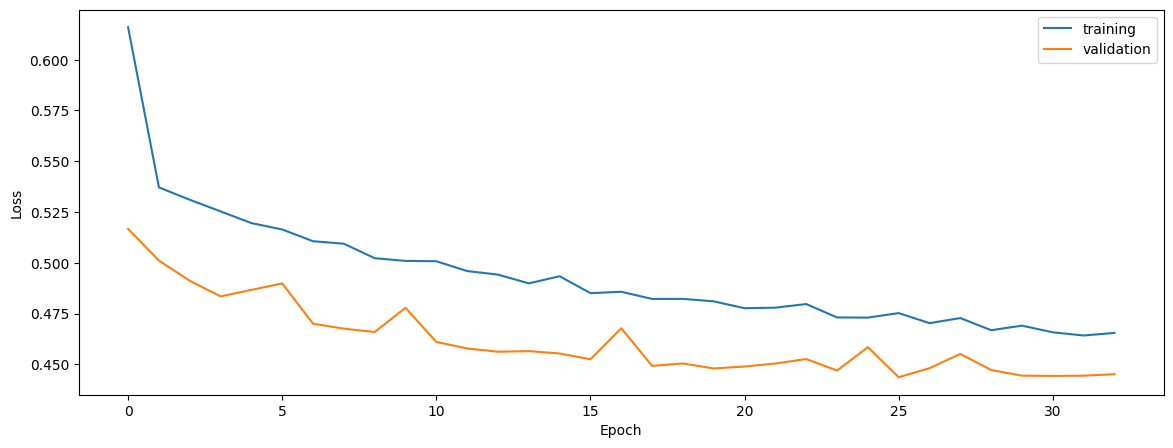

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
import numpy as np

def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1t2','fe':['k5_b25']}]
    props['balance_data'] = False
    props['include_warp'] = True
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print('native')
print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

native
0.6520176439272949
0.6546095094664371
0.6259216439073338


In [16]:
print('normalized')
print(getAccuarcy(train_true[1][train_true[2]],train_pred[train_true[2]]))
print(getAccuarcy(val_true[1][val_true[2]],val_pred[val_true[2]]))
print(getAccuarcy(test_true[1][test_true[2]],test_pred[test_true[2]]))

normalized
0.6465336813002248
0.6466057872153153
0.6184385067273072


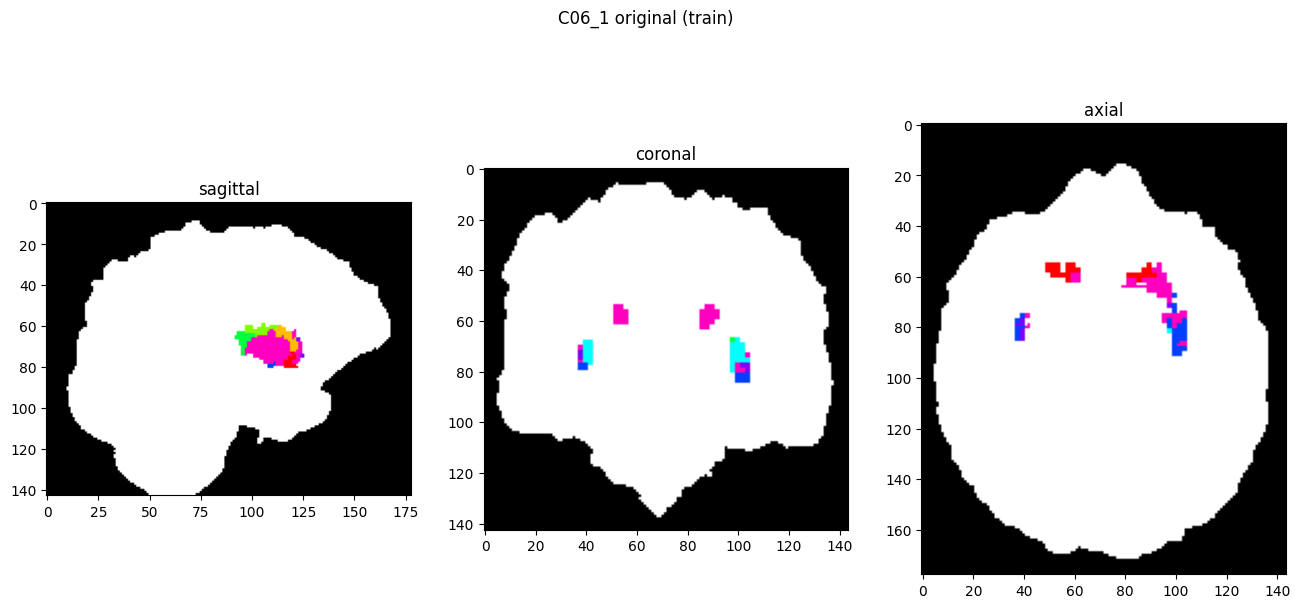

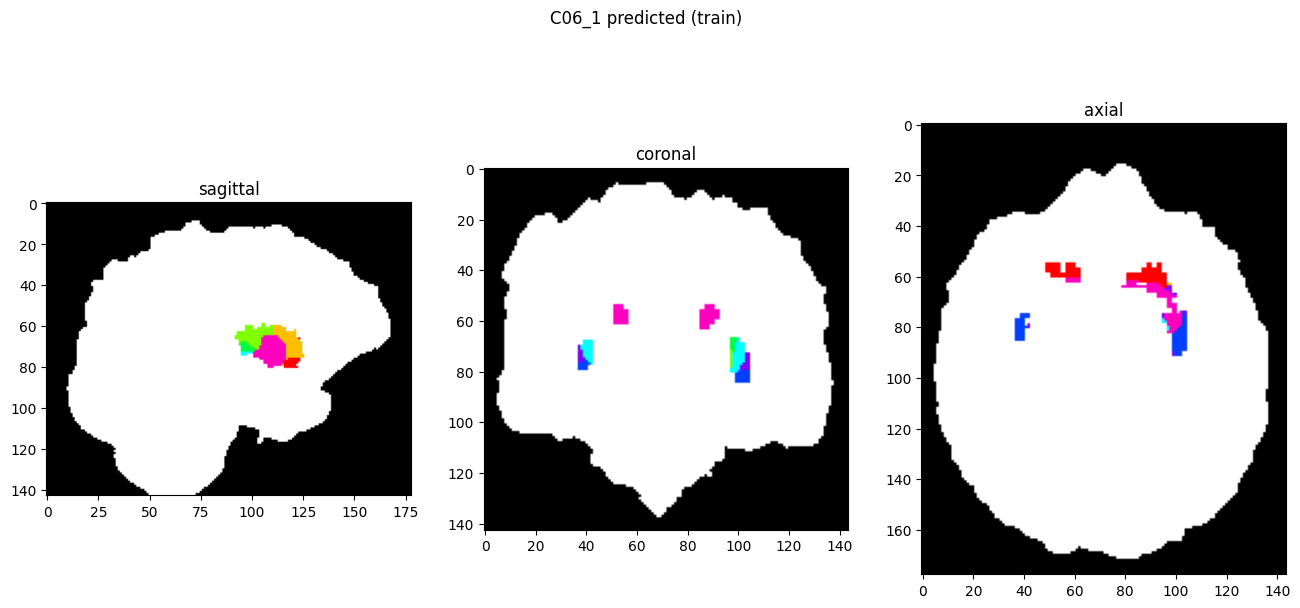

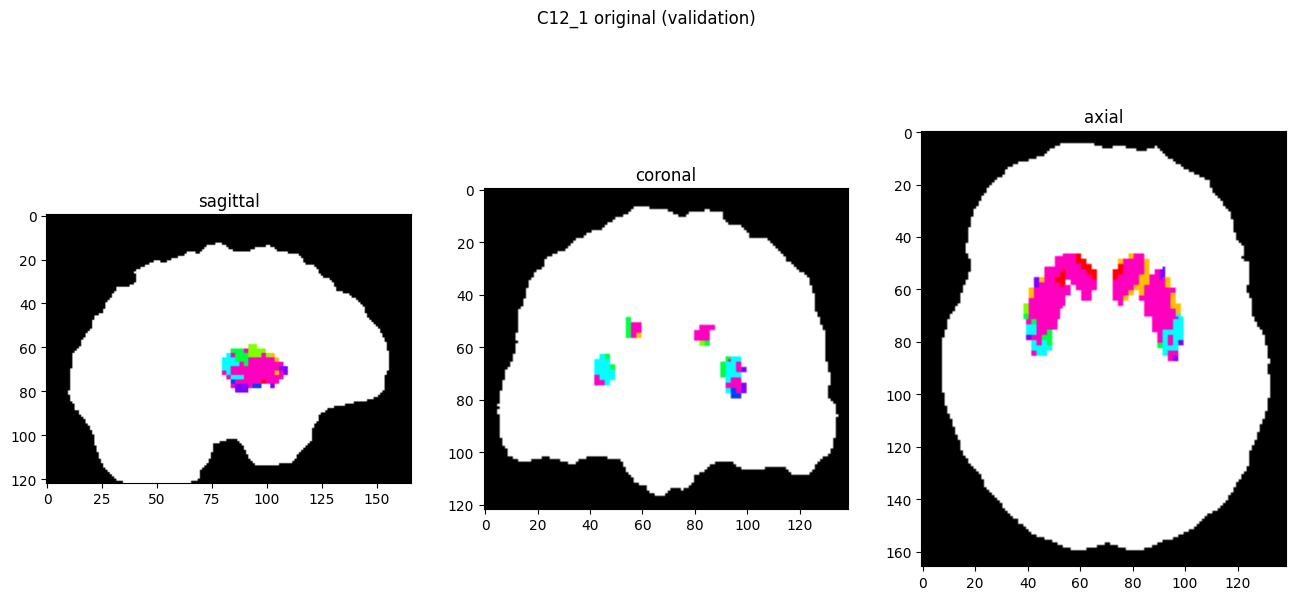

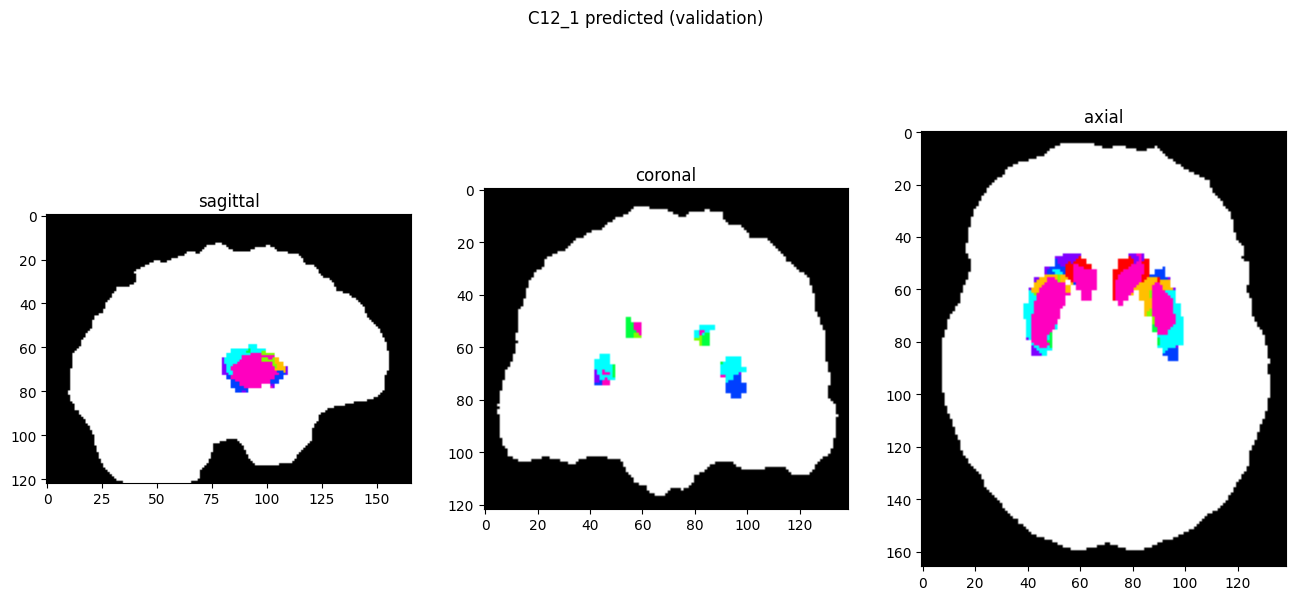

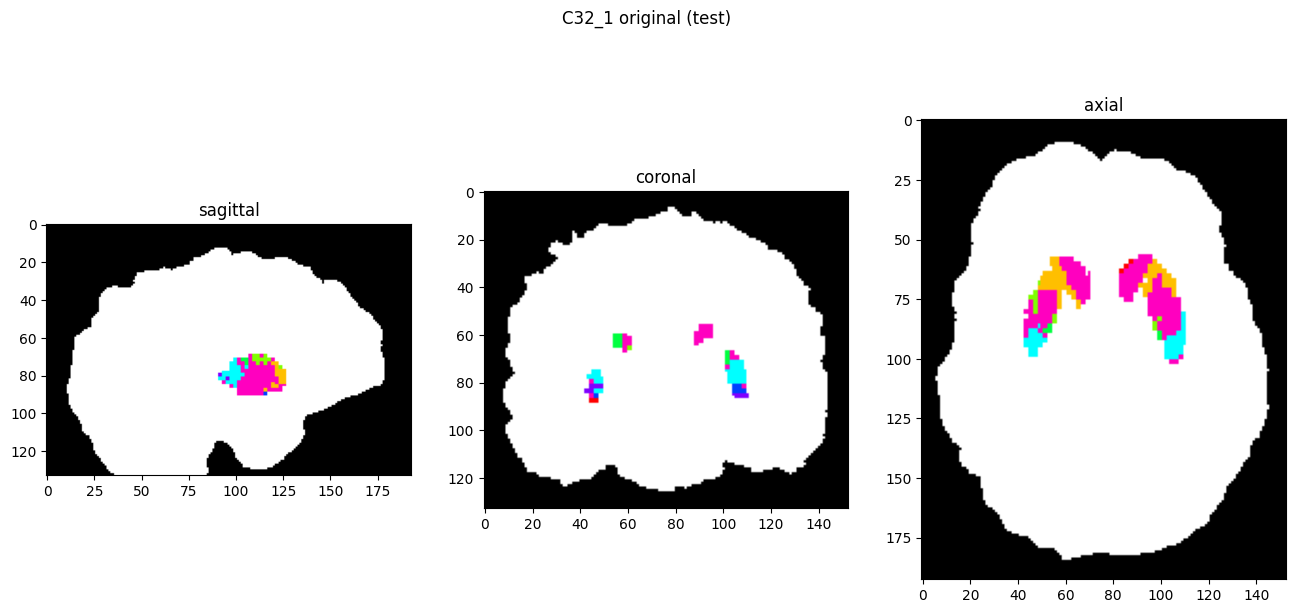

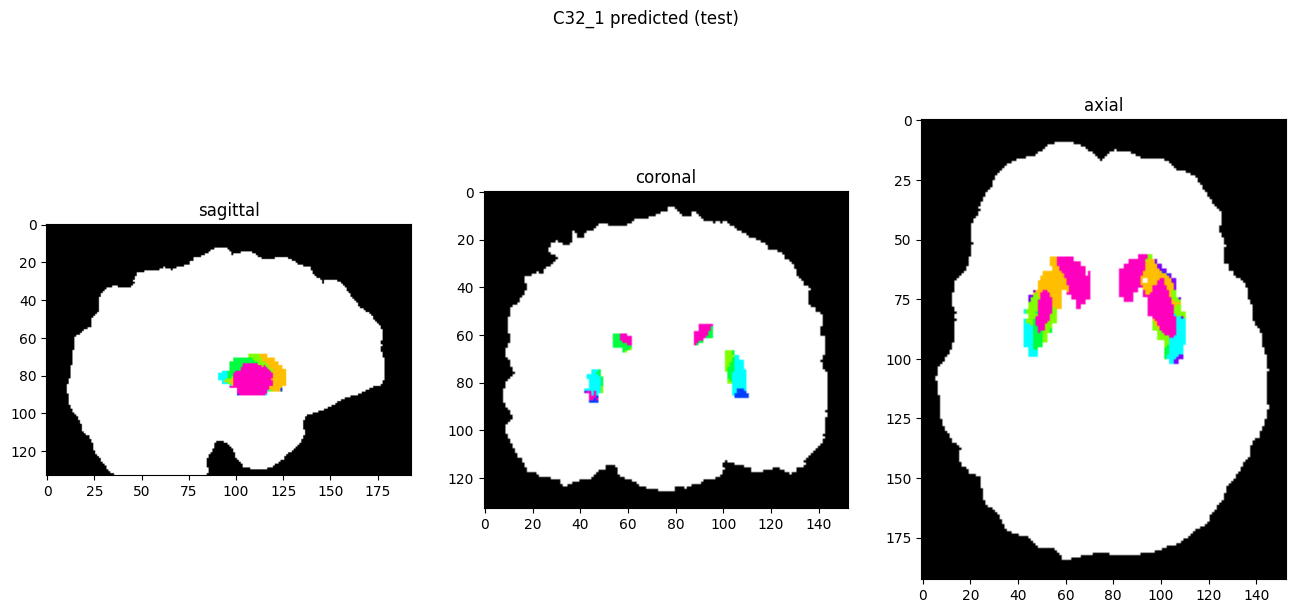

In [17]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)